## Setup

In [1]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# plt.rcParams['figure.figsize'] = [8.0, 8.0]
%config InlineBackend.figure_formats = ['retina']
plt.rcParams['figure.dpi'] = 140
plt.rcParams['savefig.dpi'] = 300

# Display settings: 
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.set_option.html
pd.set_option('display.max_column', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_colwidth', 500)
pd.set_option('expand_frame_repr', True)

# Update the default parameters for Matplotlib plots to specify various aspects of the plot's appearance,
# including the figure size, colors, gridlines, fonts, and more
plt.rcParams.update({
    # Overall Figure Aesthetics
    'figure.figsize': (8, 5),
    'figure.facecolor': 'white',

    # Axes and Grid
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.linewidth': 0.8,
    'axes.grid': True,
    'axes.grid.axis': 'y',
    'axes.grid.which': 'major',
    'grid.color': 'lightgray',
    'grid.linestyle': '-',
    'grid.linewidth': 0.5,

    # Spines (Borders)
    'axes.spines.top': False,
    'axes.spines.right': False,

    # Ticks and Tick Labels
    'xtick.bottom': True,
    'xtick.major.size': 3,
    'xtick.minor.size': 0,
    'ytick.left': True,
    'ytick.major.size': 3,
    'ytick.minor.size': 0,

    # Fonts and Text
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica', 'Arial', 'DejaVu Sans', 'Lucida Grande', 'Verdana'],
    'font.size': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 12,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,

    # Lines and Markers
    'lines.linewidth': 1.5,
    'lines.markersize': 5,

    # Colors
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'axes.titlecolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black',
})

In [2]:
!pip install xgboost

In [3]:
import importlib
import ts_utils
importlib.reload(ts_utils)


<module 'ts_utils' from '/Users/emillianlandu/Emillia_Nlandu_Capstone_Sprint1/notebooks/ts_utils.py'>

In [4]:
from ts_utils import load_and_clean_traffic_data


In [5]:
def load_and_clean_traffic_data(path):
    """
    This function loads the traffic dataset,
    drops unnecessary columns, converts the 'count_date' to datetime,
    and returns the cleaned dataframe.

    Args:
        path (str): Absolute path to data file (csv)

    Returns:
        df (DataFrame): Cleaned Pandas DataFrame
    """
    df = pd.read_csv(path)
    
    # Drop unnecessary columns
    columns_to_drop = ['count_point_id', 'region_id', 'region_ons_code', 
                        'local_authority_code', 'easting', 
                       'northing', 'latitude', 'longitude']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=False)
    
    # Convert 'count_date' to datetime
    df['count_date'] = pd.to_datetime(df['count_date'])
    
    # Optionally rename columns for consistency
    df.columns = df.columns.str.lower()
    
    return df

In [6]:
# Standard Library
import itertools
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings("ignore")

# Numerical Analysis
import numpy as np
import pandas as pd

# Plotting
from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statsmodels
from statsmodels.api import tsa
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# scikit-learn
from sklearn.model_selection import ParameterGrid, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prophet
from itertools import product
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly

# XGboost
import xgboost as xgb
from xgboost import plot_importance, plot_tree


# Utils
# from ts_utils import load_and_clean_air_traffic, \
#     lag_plots, \
#     decompose_series, \
#     perform_adf_test, \
#     perform_kpss_test

In [7]:
plt.rcParams["figure.figsize"] = (9,6)

## Data Loading and Cleaning

In [8]:
east_of_england_data = pd.read_csv('/Users/emillianlandu/Emillia_Nlandu_Capstone_Sprint1/data/east_of_england_data.csv')

matching_localities = pd.read_csv('/Users/emillianlandu/Emillia_Nlandu_Capstone_Sprint1/data/matching_localities_east_of_england.csv')

In [9]:
east_of_england_data.head()

count_point_id direction_of_travel  year  count_date  hour  region_id  \
0            6003                   N  2000  2000-03-31     7          7   
1            6003                   N  2000  2000-03-31     8          7   
2            6003                   N  2000  2000-03-31     9          7   
3            6003                   N  2000  2000-03-31    10          7   
4            6003                   N  2000  2000-03-31    11          7   

       region_name region_ons_code  local_authority_id local_authority_name  \
0  East of England       E12000006                 208         Bedfordshire   
1  East of England       E12000006                 208         Bedfordshire   
2  East of England       E12000006                 208         Bedfordshire   
3  East of England       E12000006                 208         Bedfordshire   
4  East of England       E12000006                 208         Bedfordshire   

  local_authority_code road_name road_category road_type  easting  northing  \
0            E10000001        M1            TM     Major   500244    234300   
1            E10000001        M1            TM     Major   500244    234300   
2            E10000001        M1            TM     Major   500244    234300   
3            E10000001        M1            TM     Major   500244    234300   
4            E10000001        M1            TM     Major   500244    234300   

    latitude  longitude  pedal_cycles  two_wheeled_motor_vehicles  \
0  51.998107   -0.54127             0                           6   
1  51.998107   -0.54127             0                           5   
2  51.998107   -0.54127             0                           9   
3  51.998107   -0.54127             0                           9   
4  51.998107   -0.54127             0                           4   

   cars_and_taxis  buses_and_coaches  LGVs  HGVs_2_rigid_axle  \
0          2804.0                5.0   513              171.0   
1          3100.0               11.0   436              203.0   
2          2235.0               28.0   372              226.0   
3          2259.0               26.0   457              202.0   
4          2428.0               41.0   492              220.0   

   HGVs_3_rigid_axle  HGVs_4_or_more_rigid_axle  HGVs_3_or_4_articulated_axle  \
0               40.0                       36.0                          63.0   
1               17.0                       11.0                          60.0   
2               24.0                       17.0                          85.0   
3               26.0                       22.0                          80.0   
4               24.0                       17.0                          77.0   

   HGVs_5_articulated_axle  HGVs_6_articulated_axle  all_HGVs  \
0                      223                    145.0     678.0   
1                      180                    119.0     590.0   
2                      212                    117.0     681.0   
3                      262                    157.0     749.0   
4                      218                    172.0     728.0   

   all_motor_vehicles  Month Day_of_Week  Day  
0              4006.0      3      Friday   31  
1              4142.0      3      Friday   31  
2              3325.0      3      Friday   31  
3              3500.0      3      Friday   31  
4              3693.0      3      Friday   31

In [10]:
matching_localities.head()

local_authority_id local_authority_name local_authority_code  year  \
0                  78        Hertfordshire            E10000015  1993   
1                  97       Cambridgeshire            E10000003  1993   
2                 120                Luton            E06000032  1993   
3                 123                Essex            E10000012  1993   
4                 126              Suffolk            E10000029  1993   

   link_length_km  link_length_miles  cars_and_taxis  all_motor_vehicles  
0         5084.74            3159.51    4.942400e+09        5.976800e+09  
1         4548.66            2826.41    2.793000e+09        3.524200e+09  
2          436.30             271.10    3.724000e+08        4.404000e+08  
3         7795.80            4844.09    5.746500e+09        7.011500e+09  
4         6756.78            4198.47    2.425100e+09        3.037600e+09

In [11]:
matching_localities.shape

(325, 8)

In [12]:
matching_localities.columns

Index(['local_authority_id', 'local_authority_name', 'local_authority_code',
       'year', 'link_length_km', 'link_length_miles', 'cars_and_taxis',
       'all_motor_vehicles'],
      dtype='object')

In [13]:
east_of_england_data.shape

(550056, 34)

In [14]:
east_of_england_data.columns

Index(['count_point_id', 'direction_of_travel', 'year', 'count_date', 'hour',
       'region_id', 'region_name', 'region_ons_code', 'local_authority_id',
       'local_authority_name', 'local_authority_code', 'road_name',
       'road_category', 'road_type', 'easting', 'northing', 'latitude',
       'longitude', 'pedal_cycles', 'two_wheeled_motor_vehicles',
       'cars_and_taxis', 'buses_and_coaches', 'LGVs', 'HGVs_2_rigid_axle',
       'HGVs_3_rigid_axle', 'HGVs_4_or_more_rigid_axle',
       'HGVs_3_or_4_articulated_axle', 'HGVs_5_articulated_axle',
       'HGVs_6_articulated_axle', 'all_HGVs', 'all_motor_vehicles', 'Month',
       'Day_of_Week', 'Day'],
      dtype='object')

### Data Preparation

In [15]:
import pandas as pd

# Convert 'count_date' to datetime
east_of_england_data['count_date'] = pd.to_datetime(east_of_england_data['count_date'])

# Check the data types to ensure proper formatting
print(east_of_england_data.dtypes)

# Drop unnecessary columns (modify as per your requirement)
columns_to_drop = ['count_point_id', 'direction_of_travel', 'region_id', 'region_ons_code', 
                   'local_authority_code', 'road_name', 'easting', 'northing', 'latitude', 'longitude']
east_of_england_data = east_of_england_data.drop(columns=columns_to_drop)

# Preview the cleaned data
print(east_of_england_data.head())


count_point_id                           int64
direction_of_travel                     object
year                                     int64
count_date                      datetime64[ns]
hour                                     int64
region_id                                int64
region_name                             object
region_ons_code                         object
local_authority_id                       int64
local_authority_name                    object
local_authority_code                    object
road_name                               object
road_category                           object
road_type                               object
easting                                  int64
northing                                 int64
latitude                               float64
longitude                              float64
pedal_cycles                             int64
two_wheeled_motor_vehicles               int64
cars_and_taxis                         float64
buses_and_coa

In [16]:

print(matching_localities.dtypes)
print(matching_localities.head())


local_authority_id        int64
local_authority_name     object
local_authority_code     object
year                      int64
link_length_km          float64
link_length_miles       float64
cars_and_taxis          float64
all_motor_vehicles      float64
dtype: object
   local_authority_id local_authority_name local_authority_code  year  \
0                  78        Hertfordshire            E10000015  1993   
1                  97       Cambridgeshire            E10000003  1993   
2                 120                Luton            E06000032  1993   
3                 123                Essex            E10000012  1993   
4                 126              Suffolk            E10000029  1993   

   link_length_km  link_length_miles  cars_and_taxis  all_motor_vehicles  
0         5084.74            3159.51    4.942400e+09        5.976800e+09  
1         4548.66            2826.41    2.793000e+09        3.524200e+09  
2          436.30             271.10    3.724000e+08        4.4040

In [17]:
# Ensure 'local_authority_id' is the same type in both datasets (convert to string)
east_of_england_data['local_authority_id'] = east_of_england_data['local_authority_id'].astype(str)
matching_localities['local_authority_id'] = matching_localities['local_authority_id'].astype(str)

# Merge the datasets on 'local_authority_id' and 'year'
merged_data = pd.merge(east_of_england_data, matching_localities, on=['local_authority_id', 'year'], how='inner')

# Check the merged dataset
merged_data.head()


year count_date  hour      region_name local_authority_id  \
0  2000 2000-03-31     7  East of England                208   
1  2000 2000-03-31     8  East of England                208   
2  2000 2000-03-31     9  East of England                208   
3  2000 2000-03-31    10  East of England                208   
4  2000 2000-03-31    11  East of England                208   

  local_authority_name_x road_category road_type  pedal_cycles  \
0           Bedfordshire            TM     Major             0   
1           Bedfordshire            TM     Major             0   
2           Bedfordshire            TM     Major             0   
3           Bedfordshire            TM     Major             0   
4           Bedfordshire            TM     Major             0   

   two_wheeled_motor_vehicles  cars_and_taxis_x  buses_and_coaches  LGVs  \
0                           6            2804.0                5.0   513   
1                           5            3100.0               11.0   436   
2                           9            2235.0               28.0   372   
3                           9            2259.0               26.0   457   
4                           4            2428.0               41.0   492   

   HGVs_2_rigid_axle  HGVs_3_rigid_axle  HGVs_4_or_more_rigid_axle  \
0              171.0               40.0                       36.0   
1              203.0               17.0                       11.0   
2              226.0               24.0                       17.0   
3              202.0               26.0                       22.0   
4              220.0               24.0                       17.0   

   HGVs_3_or_4_articulated_axle  HGVs_5_articulated_axle  \
0                          63.0                      223   
1                          60.0                      180   
2                          85.0                      212   
3                          80.0                      262   
4                          77.0                      218   

   HGVs_6_articulated_axle  all_HGVs  all_motor_vehicles_x  Month Day_of_Week  \
0                    145.0     678.0                4006.0      3      Friday   
1                    119.0     590.0                4142.0      3      Friday   
2                    117.0     681.0                3325.0      3      Friday   
3                    157.0     749.0                3500.0      3      Friday   
4                    172.0     728.0                3693.0      3      Friday   

   Day local_authority_name_y local_authority_code  link_length_km  \
0   31           Bedfordshire            E10000001         2311.17   
1   31           Bedfordshire            E10000001         2311.17   
2   31           Bedfordshire            E10000001         2311.17   
3   31           Bedfordshire            E10000001         2311.17   
4   31           Bedfordshire            E10000001         2311.17   

   link_length_miles  cars_and_taxis_y  all_motor_vehicles_y  
0            1436.09      1.854200e+09          2.348900e+09  
1            1436.09      1.854200e+09          2.348900e+09  
2            1436.09      1.854200e+09          2.348900e+09  
3            1436.09      1.854200e+09          2.348900e+09  
4            1436.09      1.854200e+09          2.348900e+09

In [18]:
merged_data.shape

(549312, 30)

In [19]:
merged_data['all_motor_vehicles_x'].head()

0    4006.0
1    4142.0
2    3325.0
3    3500.0
4    3693.0
Name: all_motor_vehicles_x, dtype: float64

In [20]:
merged_data['all_motor_vehicles_x'].head()

0    4006.0
1    4142.0
2    3325.0
3    3500.0
4    3693.0
Name: all_motor_vehicles_x, dtype: float64

## EDA: Stationarity 

### Check Redundancies Columns

In [21]:
# Drop redundant columns (from matching_localities) if not needed
merged_data = merged_data.drop(columns=['cars_and_taxis_y', 'all_motor_vehicles_y', 'local_authority_name_y', 'region_name'])

# Inspect the remaining columns
merged_data.columns


Index(['year', 'count_date', 'hour', 'local_authority_id',
       'local_authority_name_x', 'road_category', 'road_type', 'pedal_cycles',
       'two_wheeled_motor_vehicles', 'cars_and_taxis_x', 'buses_and_coaches',
       'LGVs', 'HGVs_2_rigid_axle', 'HGVs_3_rigid_axle',
       'HGVs_4_or_more_rigid_axle', 'HGVs_3_or_4_articulated_axle',
       'HGVs_5_articulated_axle', 'HGVs_6_articulated_axle', 'all_HGVs',
       'all_motor_vehicles_x', 'Month', 'Day_of_Week', 'Day',
       'local_authority_code', 'link_length_km', 'link_length_miles'],
      dtype='object')

### Hourly Grouping Aggregated Data

In [22]:
# Convert 'count_date' to datetime if it's not already
merged_data['count_date'] = pd.to_datetime(merged_data['count_date'])

# Combine 'count_date' and 'hour' to create a datetime 'timestamp'
merged_data['timestamp'] = pd.to_datetime(merged_data['count_date'].astype(str) + ' ' + merged_data['hour'].astype(str).str.zfill(2) + ':00')

print(merged_data[['timestamp', 'count_date', 'hour']].head())


            timestamp count_date  hour
0 2000-03-31 07:00:00 2000-03-31     7
1 2000-03-31 08:00:00 2000-03-31     8
2 2000-03-31 09:00:00 2000-03-31     9
3 2000-03-31 10:00:00 2000-03-31    10
4 2000-03-31 11:00:00 2000-03-31    11


In [23]:
# Group by 'timestamp' and sum relevant traffic-related columns
traffic_columns = ['cars_and_taxis_x', 'all_motor_vehicles_x', 'pedal_cycles', 'two_wheeled_motor_vehicles', 
                   'buses_and_coaches', 'LGVs', 'all_HGVs']

hourly_grouped_data = merged_data.groupby('timestamp')[traffic_columns].sum().reset_index()

# Inspect hourly grouped data
print(hourly_grouped_data.head())

            timestamp  cars_and_taxis_x  all_motor_vehicles_x  pedal_cycles  \
0 2000-03-17 07:00:00            6364.0                8187.0           119   
1 2000-03-17 08:00:00            8351.0               10022.0           240   
2 2000-03-17 09:00:00            6071.0                7651.0           103   
3 2000-03-17 10:00:00            5596.0                7203.0            57   
4 2000-03-17 11:00:00            5771.0                7458.0            45   

   two_wheeled_motor_vehicles  buses_and_coaches  LGVs  all_HGVs  
0                         141               82.0  1226     374.0  
1                         131              113.0   996     431.0  
2                          73               76.0   974     457.0  
3                          65               74.0   968     500.0  
4                          67               57.0  1041     522.0  


### Daily Aggregated Data

In [24]:
# Extract the 'count_date' from the 'timestamp' to group at the daily level
hourly_grouped_data['count_date'] = hourly_grouped_data['timestamp'].dt.date

# Group by 'count_date' (daily) and sum the traffic columns
daily_grouped_data = hourly_grouped_data.groupby('count_date')[traffic_columns].sum().reset_index()

# Inspect daily grouped data
print(daily_grouped_data.head())

   count_date  cars_and_taxis_x  all_motor_vehicles_x  pedal_cycles  \
0  2000-03-17           79773.0               98167.0          1272   
1  2000-03-20          141798.0              181149.0           734   
2  2000-03-21          111629.0              145448.0           421   
3  2000-03-22           96640.0              124106.0           714   
4  2000-03-23          101604.0              128779.0           108   

   two_wheeled_motor_vehicles  buses_and_coaches   LGVs  all_HGVs  
0                        1218              953.0  11423    4800.0  
1                        1223             1484.0  20809   15835.0  
2                        1786             1151.0  19959   10923.0  
3                         892             1474.0  15521    9579.0  
4                         884              655.0  17011    8625.0  


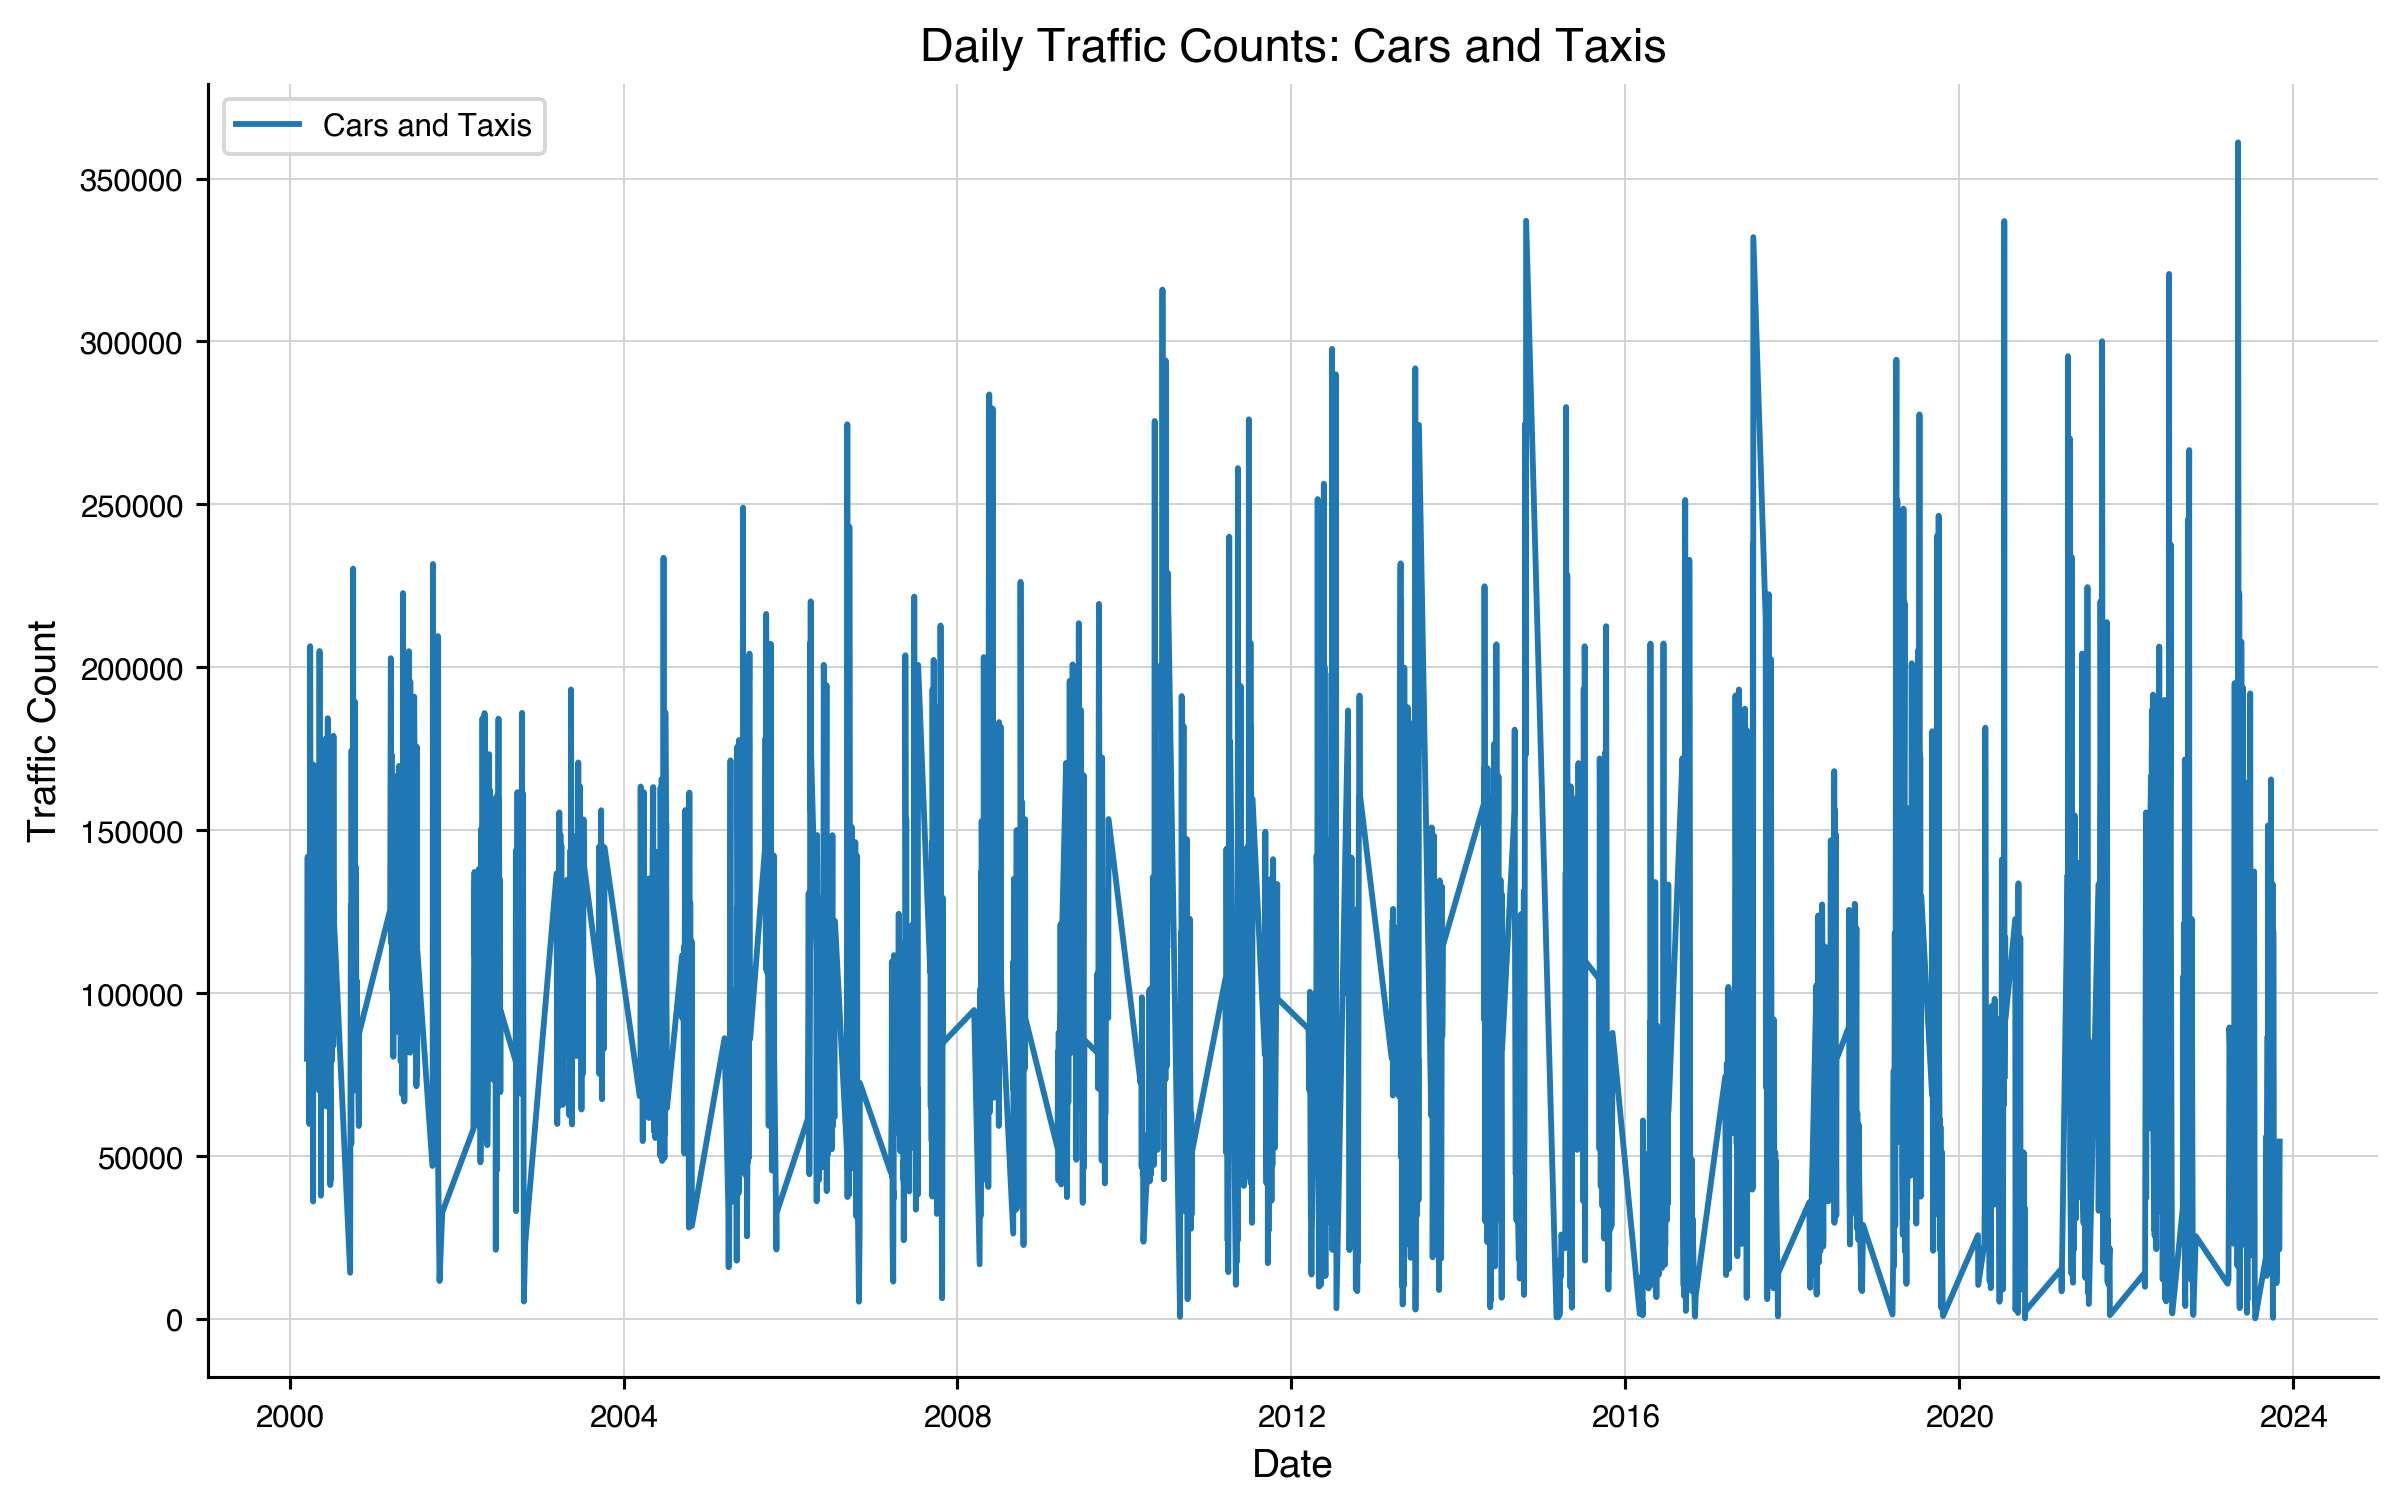

In [25]:
import matplotlib.pyplot as plt

# Plot the time series for 'cars_and_taxis_x'
plt.figure(figsize=(10, 6))
plt.plot(daily_grouped_data['count_date'], daily_grouped_data['cars_and_taxis_x'], label='Cars and Taxis')
plt.title('Daily Traffic Counts: Cars and Taxis')
plt.xlabel('Date')
plt.ylabel('Traffic Count')
plt.legend()
plt.grid(True)
plt.show()

### Monthly Aggregated Data

In [26]:
# Convert 'count_date' back to datetime for resampling
daily_grouped_data['count_date'] = pd.to_datetime(daily_grouped_data['count_date'])

# Set 'count_date' as the index for resampling
daily_grouped_data.set_index('count_date', inplace=True)

# Resample at a monthly level, summing the values for each month
monthly_data = daily_grouped_data.resample('M').sum()

# Reset the index to have 'count_date' (now at a monthly frequency) as a column
monthly_data = monthly_data.reset_index()

# Inspect the final monthly resampled data
print(monthly_data.head())


  count_date  cars_and_taxis_x  all_motor_vehicles_x  pedal_cycles  \
0 2000-03-31         1238143.0             1603322.0          5647   
1 2000-04-30         1127790.0             1475538.0          3820   
2 2000-05-31         2165510.0             2848495.0         10475   
3 2000-06-30         2151728.0             2814927.0          8681   
4 2000-07-31         1241976.0             1646437.0          8697   

   two_wheeled_motor_vehicles  buses_and_coaches    LGVs  all_HGVs  
0                       11730            13024.0  197412  143013.0  
1                       11115            11686.0  188671  136276.0  
2                       22610            21534.0  361327  277514.0  
3                       26299            23509.0  351787  261604.0  
4                       13519            13936.0  211504  165502.0  


In [27]:
import matplotlib.pyplot as plt

def plot_rolling_mean_and_std(series: pd.Series, window: int) -> None:
    """
    This function plots the rolling mean and rolling standard deviation
    of a time series to help visually inspect stationarity.
    
    Args:
        series (pd.Series): Time series data (single column)
        window (int): Window size for rolling calculations (in time units)
        
    Returns: 
        None
    """
    # Get Rolling Mean and STD
    roll_mean = series.rolling(window=window).mean()
    roll_std = series.rolling(window=window).std()

    # Plot original series, rolling mean, and rolling standard deviation
    plt.figure(figsize=(12, 6))
    plt.plot(series, label='Original', color='blue', alpha=0.5)
    plt.plot(roll_mean, label=f'Rolling Mean (window={window})', color='red')
    plt.plot(roll_std, label=f'Rolling STD (window={window})', color='green')
    
    # Adding titles and labels
    plt.title('Rolling Mean & Standard Deviation')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

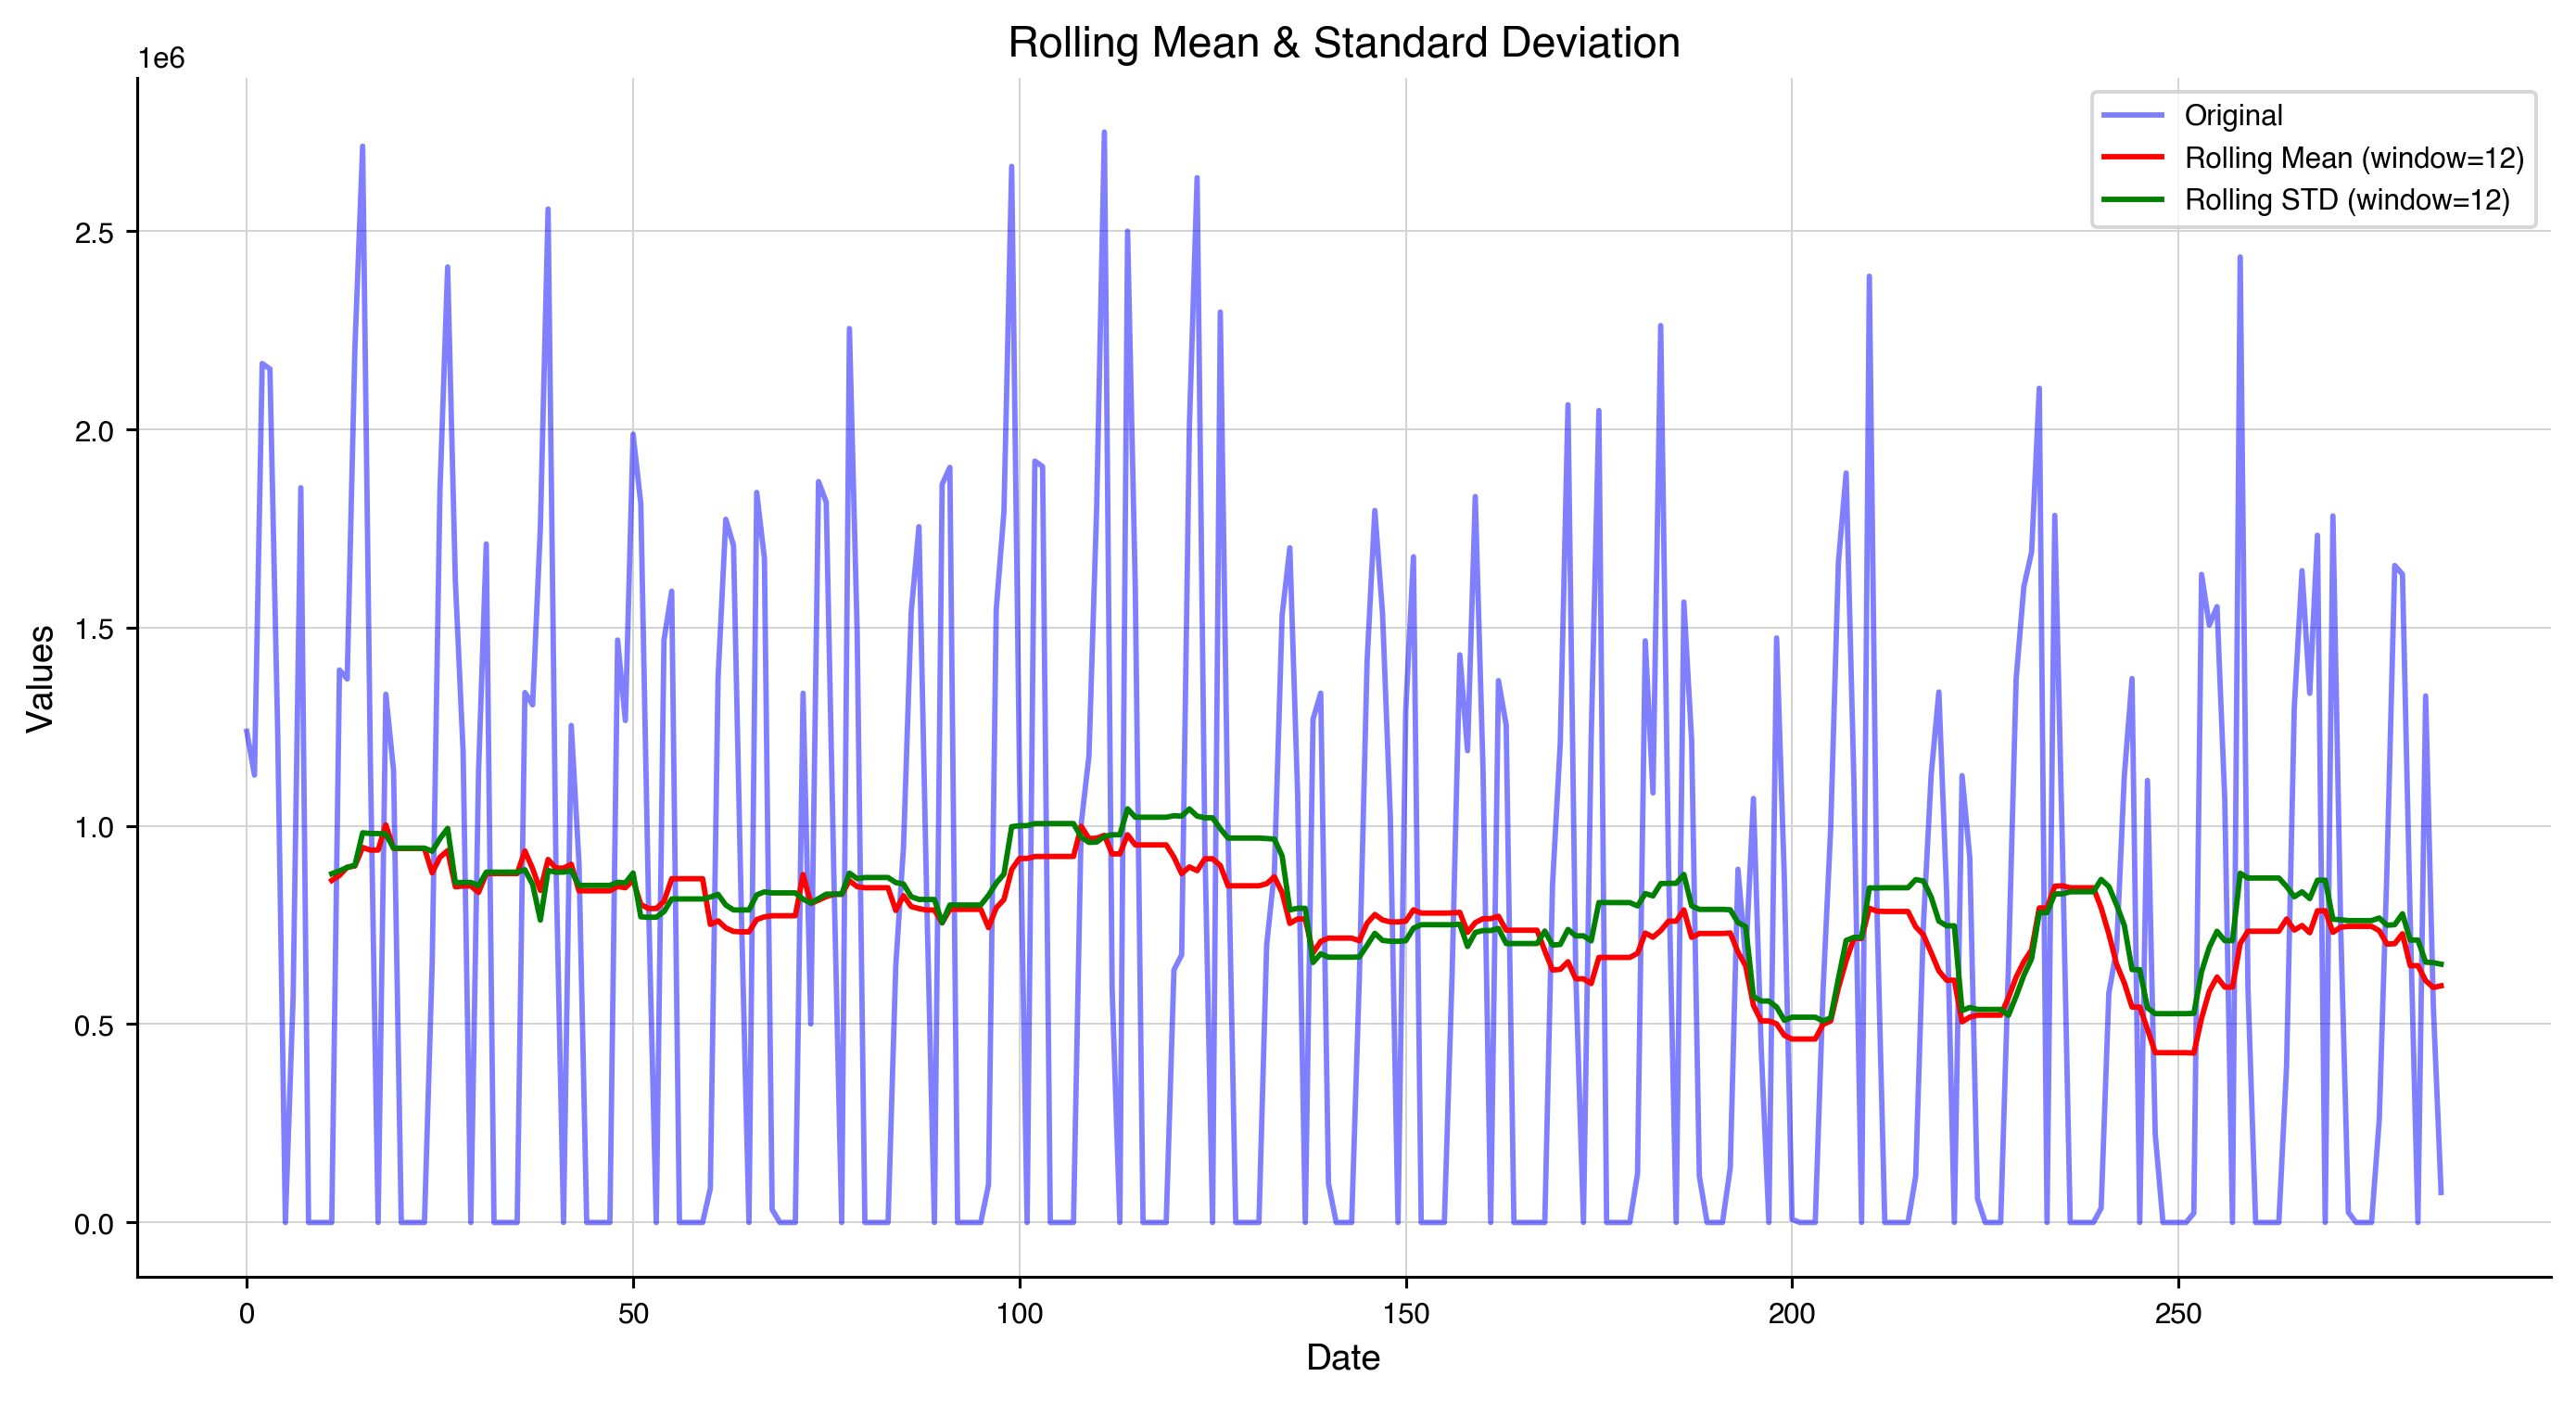

In [28]:
# Plot the rolling mean and standard deviation for a 12-month window 
plot_rolling_mean_and_std(monthly_data['cars_and_taxis_x'], window=12)  

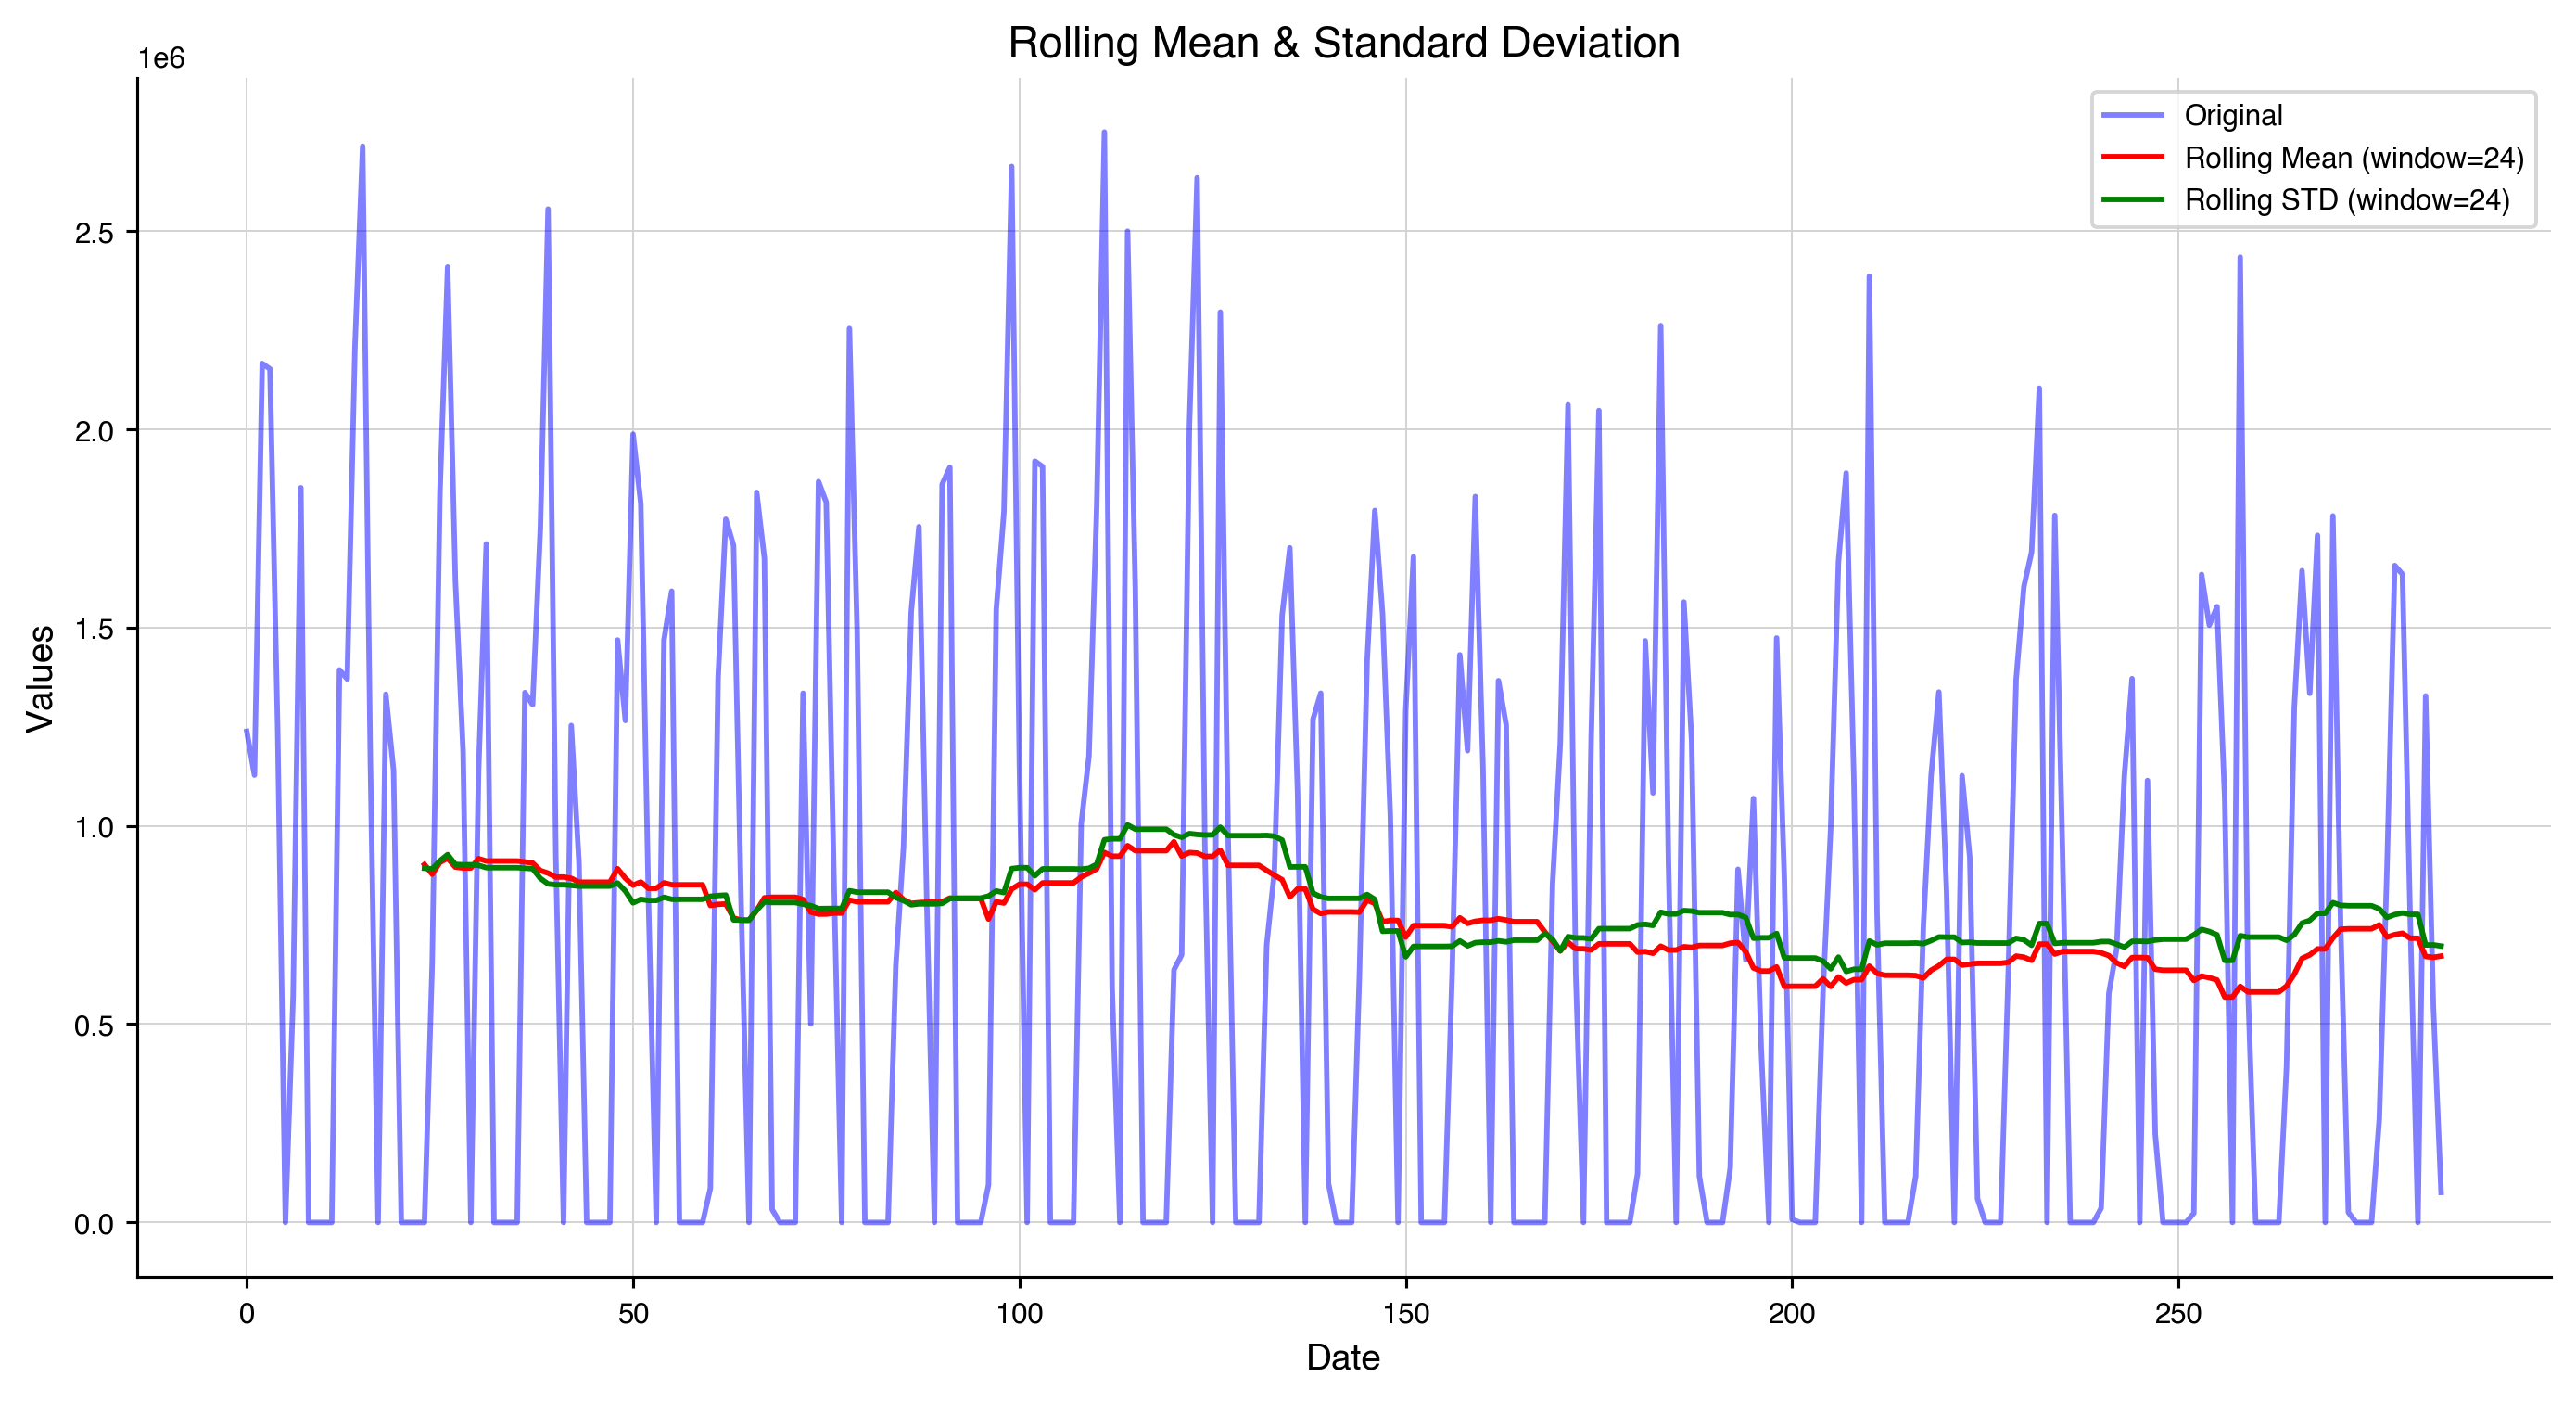

In [29]:
# Plot the rolling mean and standard deviation for a 24-month window 
plot_rolling_mean_and_std(monthly_data['cars_and_taxis_x'], window=24)

### Dealing with Non-Stationarity

#### Differencing

In [33]:
from statsmodels.tsa.stattools import adfuller

def perform_adf_test(series: pd.Series) -> None:
    """
    Perform the Augmented Dickey-Fuller test to check stationarity.
    
    Args:
        series (pd.Series): Time series data
    
    Returns:
        None
    """
    result = adfuller(series.dropna())  # Dropping NaN values if any
    
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# Perform the ADF test on the same series
perform_adf_test(monthly_data['cars_and_taxis_x'])

ADF Statistic: -3.866918
p-value: 0.002292
Critical Values:
   1%: -3.454988209954765
   5%: -2.8723857312734613
   10%: -2.572549407997327


In [34]:
# Apply first-order differencing
diff_data = monthly_data['cars_and_taxis_x'].diff().dropna()

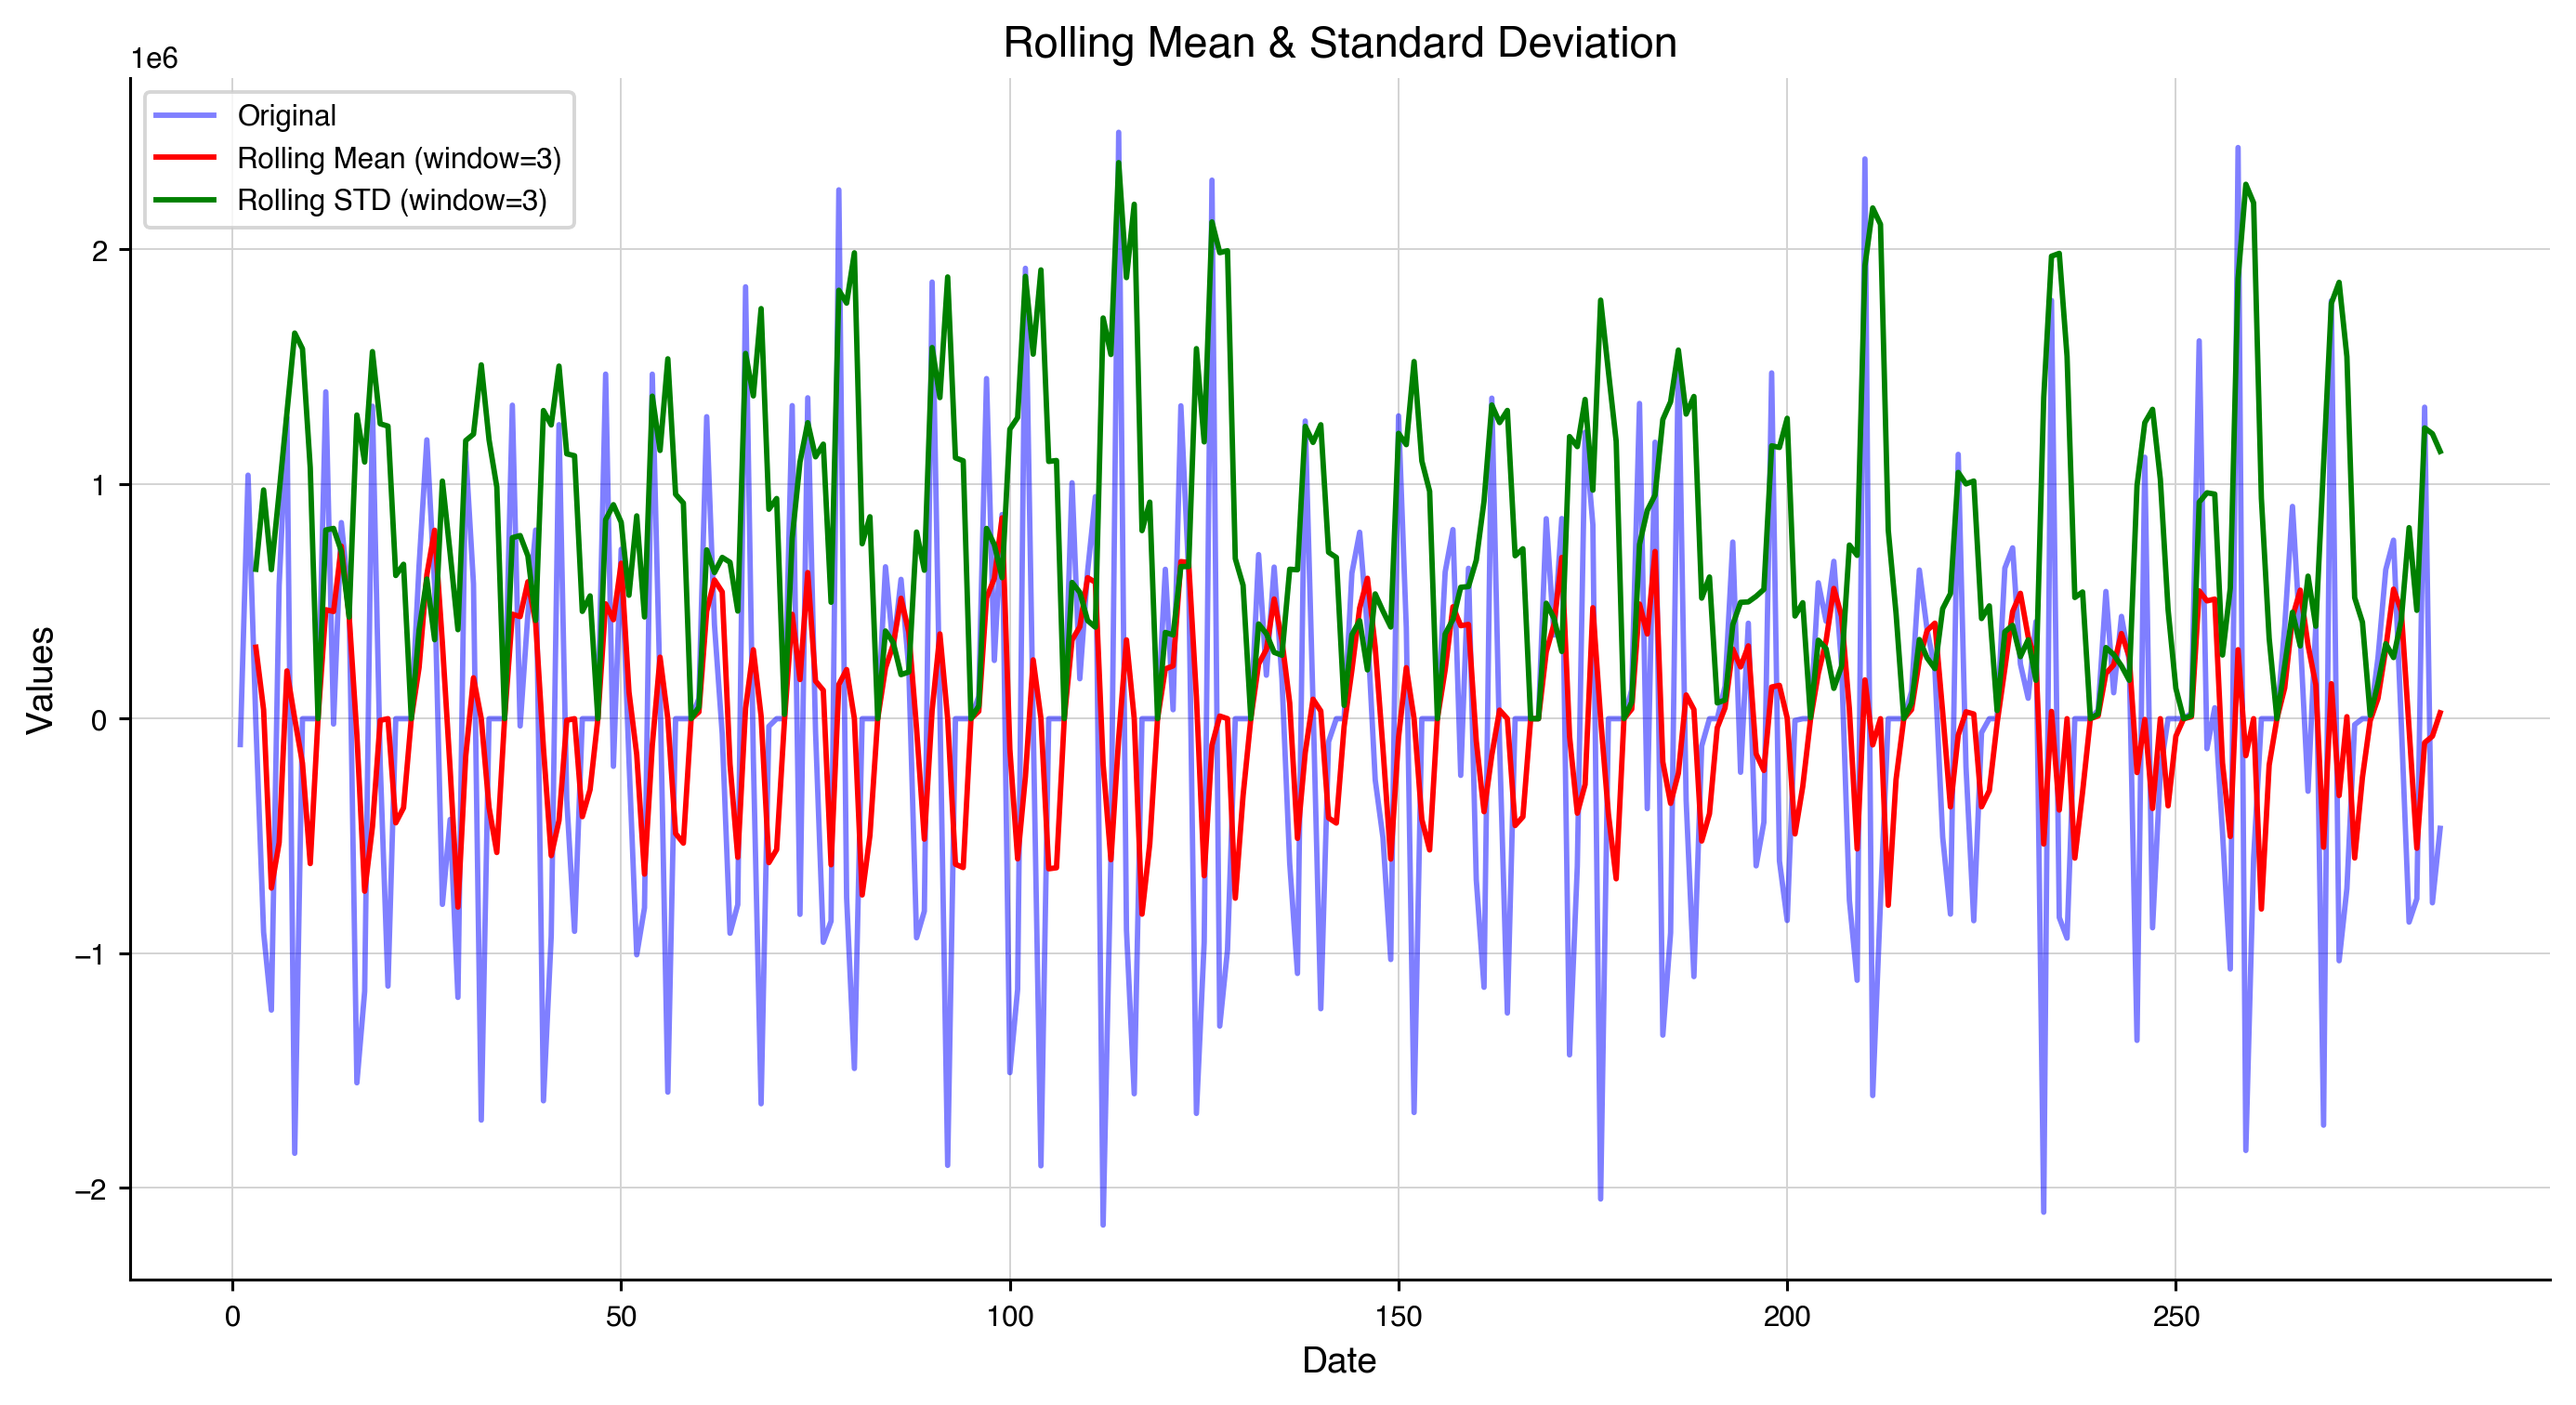

In [35]:
# Plot rolling mean and standard deviation after differencing
plot_rolling_mean_and_std(diff_data, window=3)

In [36]:
# Perform the Augmented Dickey-Fuller test on the differenced data
perform_adf_test(diff_data)

ADF Statistic: -6.832172
p-value: 0.000000
Critical Values:
   1%: -3.4548039258751206
   5%: -2.872304928618605
   10%: -2.5725063100137175


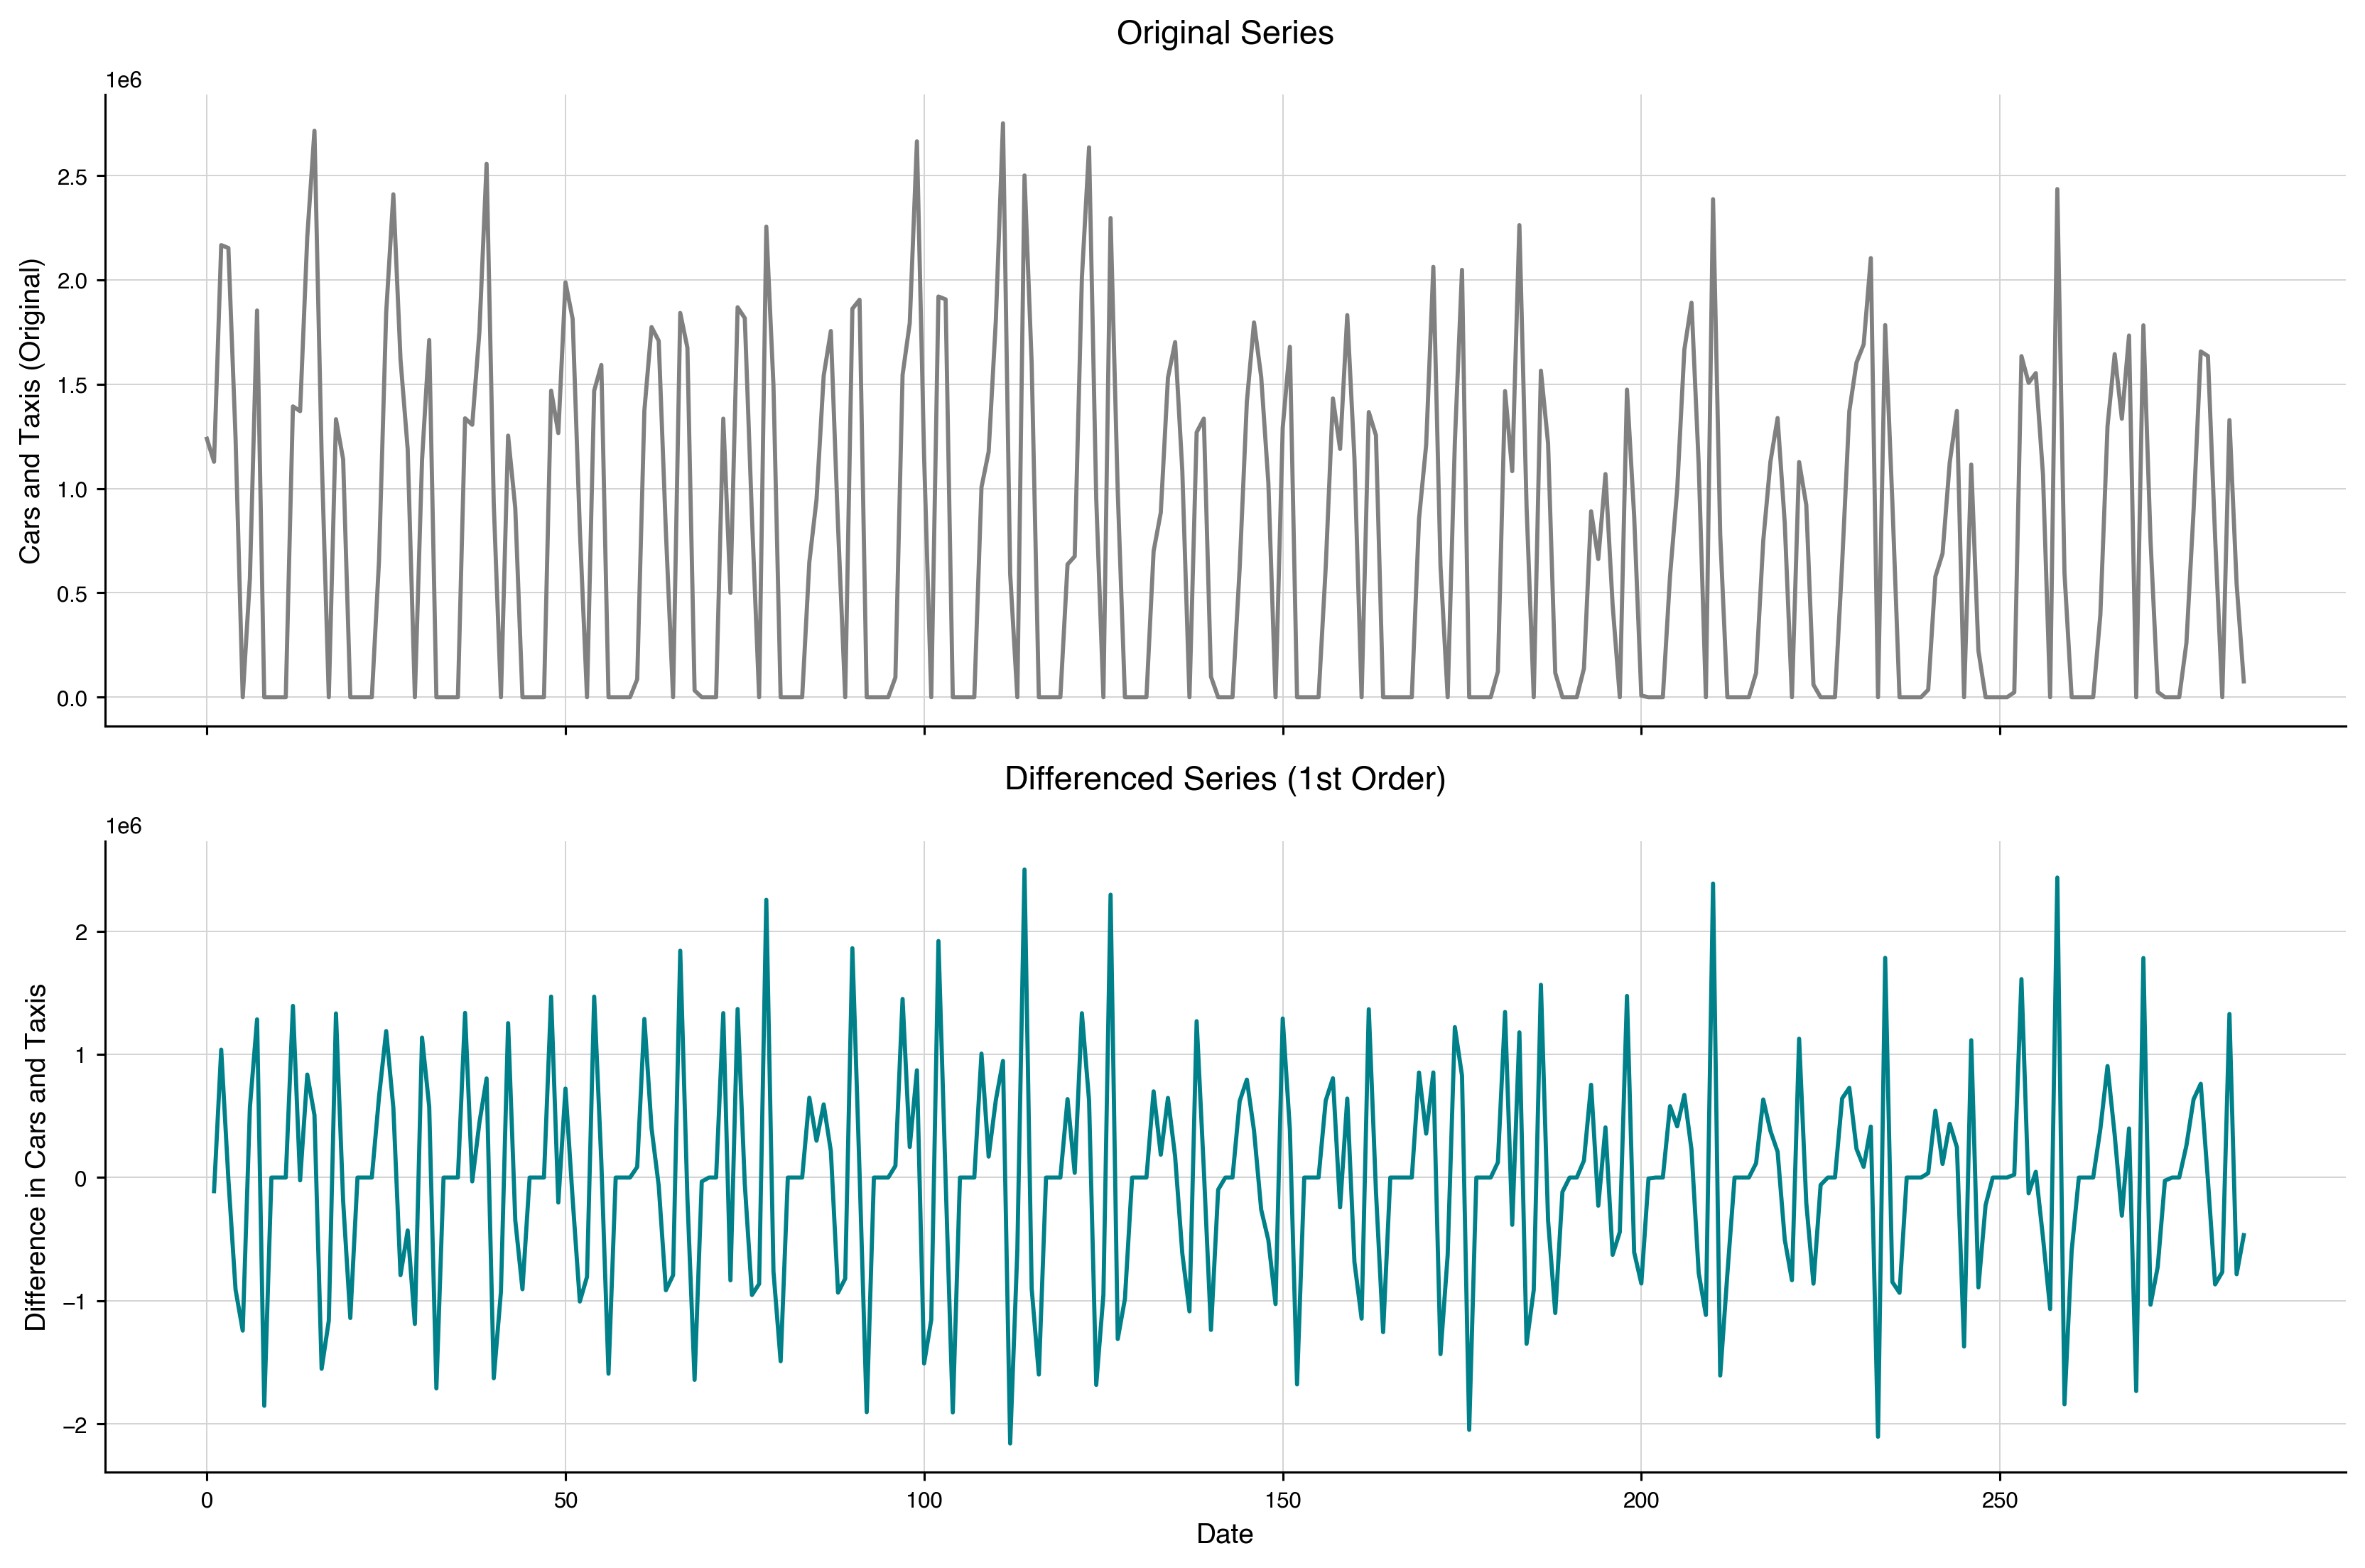

In [32]:
import matplotlib.pyplot as plt


# Create the figure and two subplots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 8))

# Plot the original data in the first subplot
ax1.plot(monthly_data['cars_and_taxis_x'], color='#808080')
ax1.set_ylabel('Cars and Taxis (Original)')
ax1.set_title('Original Series\n')

# Plot the differenced data in the second subplot
ax2.plot(diff_data, color='#008088')
ax2.set_xlabel('Date')
ax2.set_ylabel('Difference in Cars and Taxis')
ax2.set_title('Differenced Series (1st Order)\n')

# Add a grid and show the plot
ax1.grid(True)
ax2.grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## EDA: Autocorrelation

In [37]:

from pandas.plotting import lag_plot
import matplotlib.pyplot as plt

def lag_plots(series: pd.Series, lags=[1, 12, 24]) -> None:
    """
    This function plots the lag correlation between 
    current y(t) and y(t-1), y(t-12), and y(t-24) lags (default) 
    or any custom lag provided.
    
    Args:
        series (pd.Series): The time series data (single column).
        lags (list): List of lag values for which to create lag plots.
    
    Returns:
        None
    """
    
    # Number of subplots based on the number of lags
    num_lags = len(lags)
    fig, axes = plt.subplots(1, num_lags, figsize=(16, 9), facecolor='w')
    
    # Loop over the lags to create lag plots for each specified lag
    for i, lag in enumerate(lags):
        lag_plot(series, lag=lag, ax=axes[i], c='#187bcd' if i % 2 == 0 else 'grey')
        axes[i].set_title(f"y(t+{lag})", fontsize=15, pad=10)
        axes[i].grid(linestyle=":", color='grey')
    
    
    plt.tight_layout()
    plt.show()


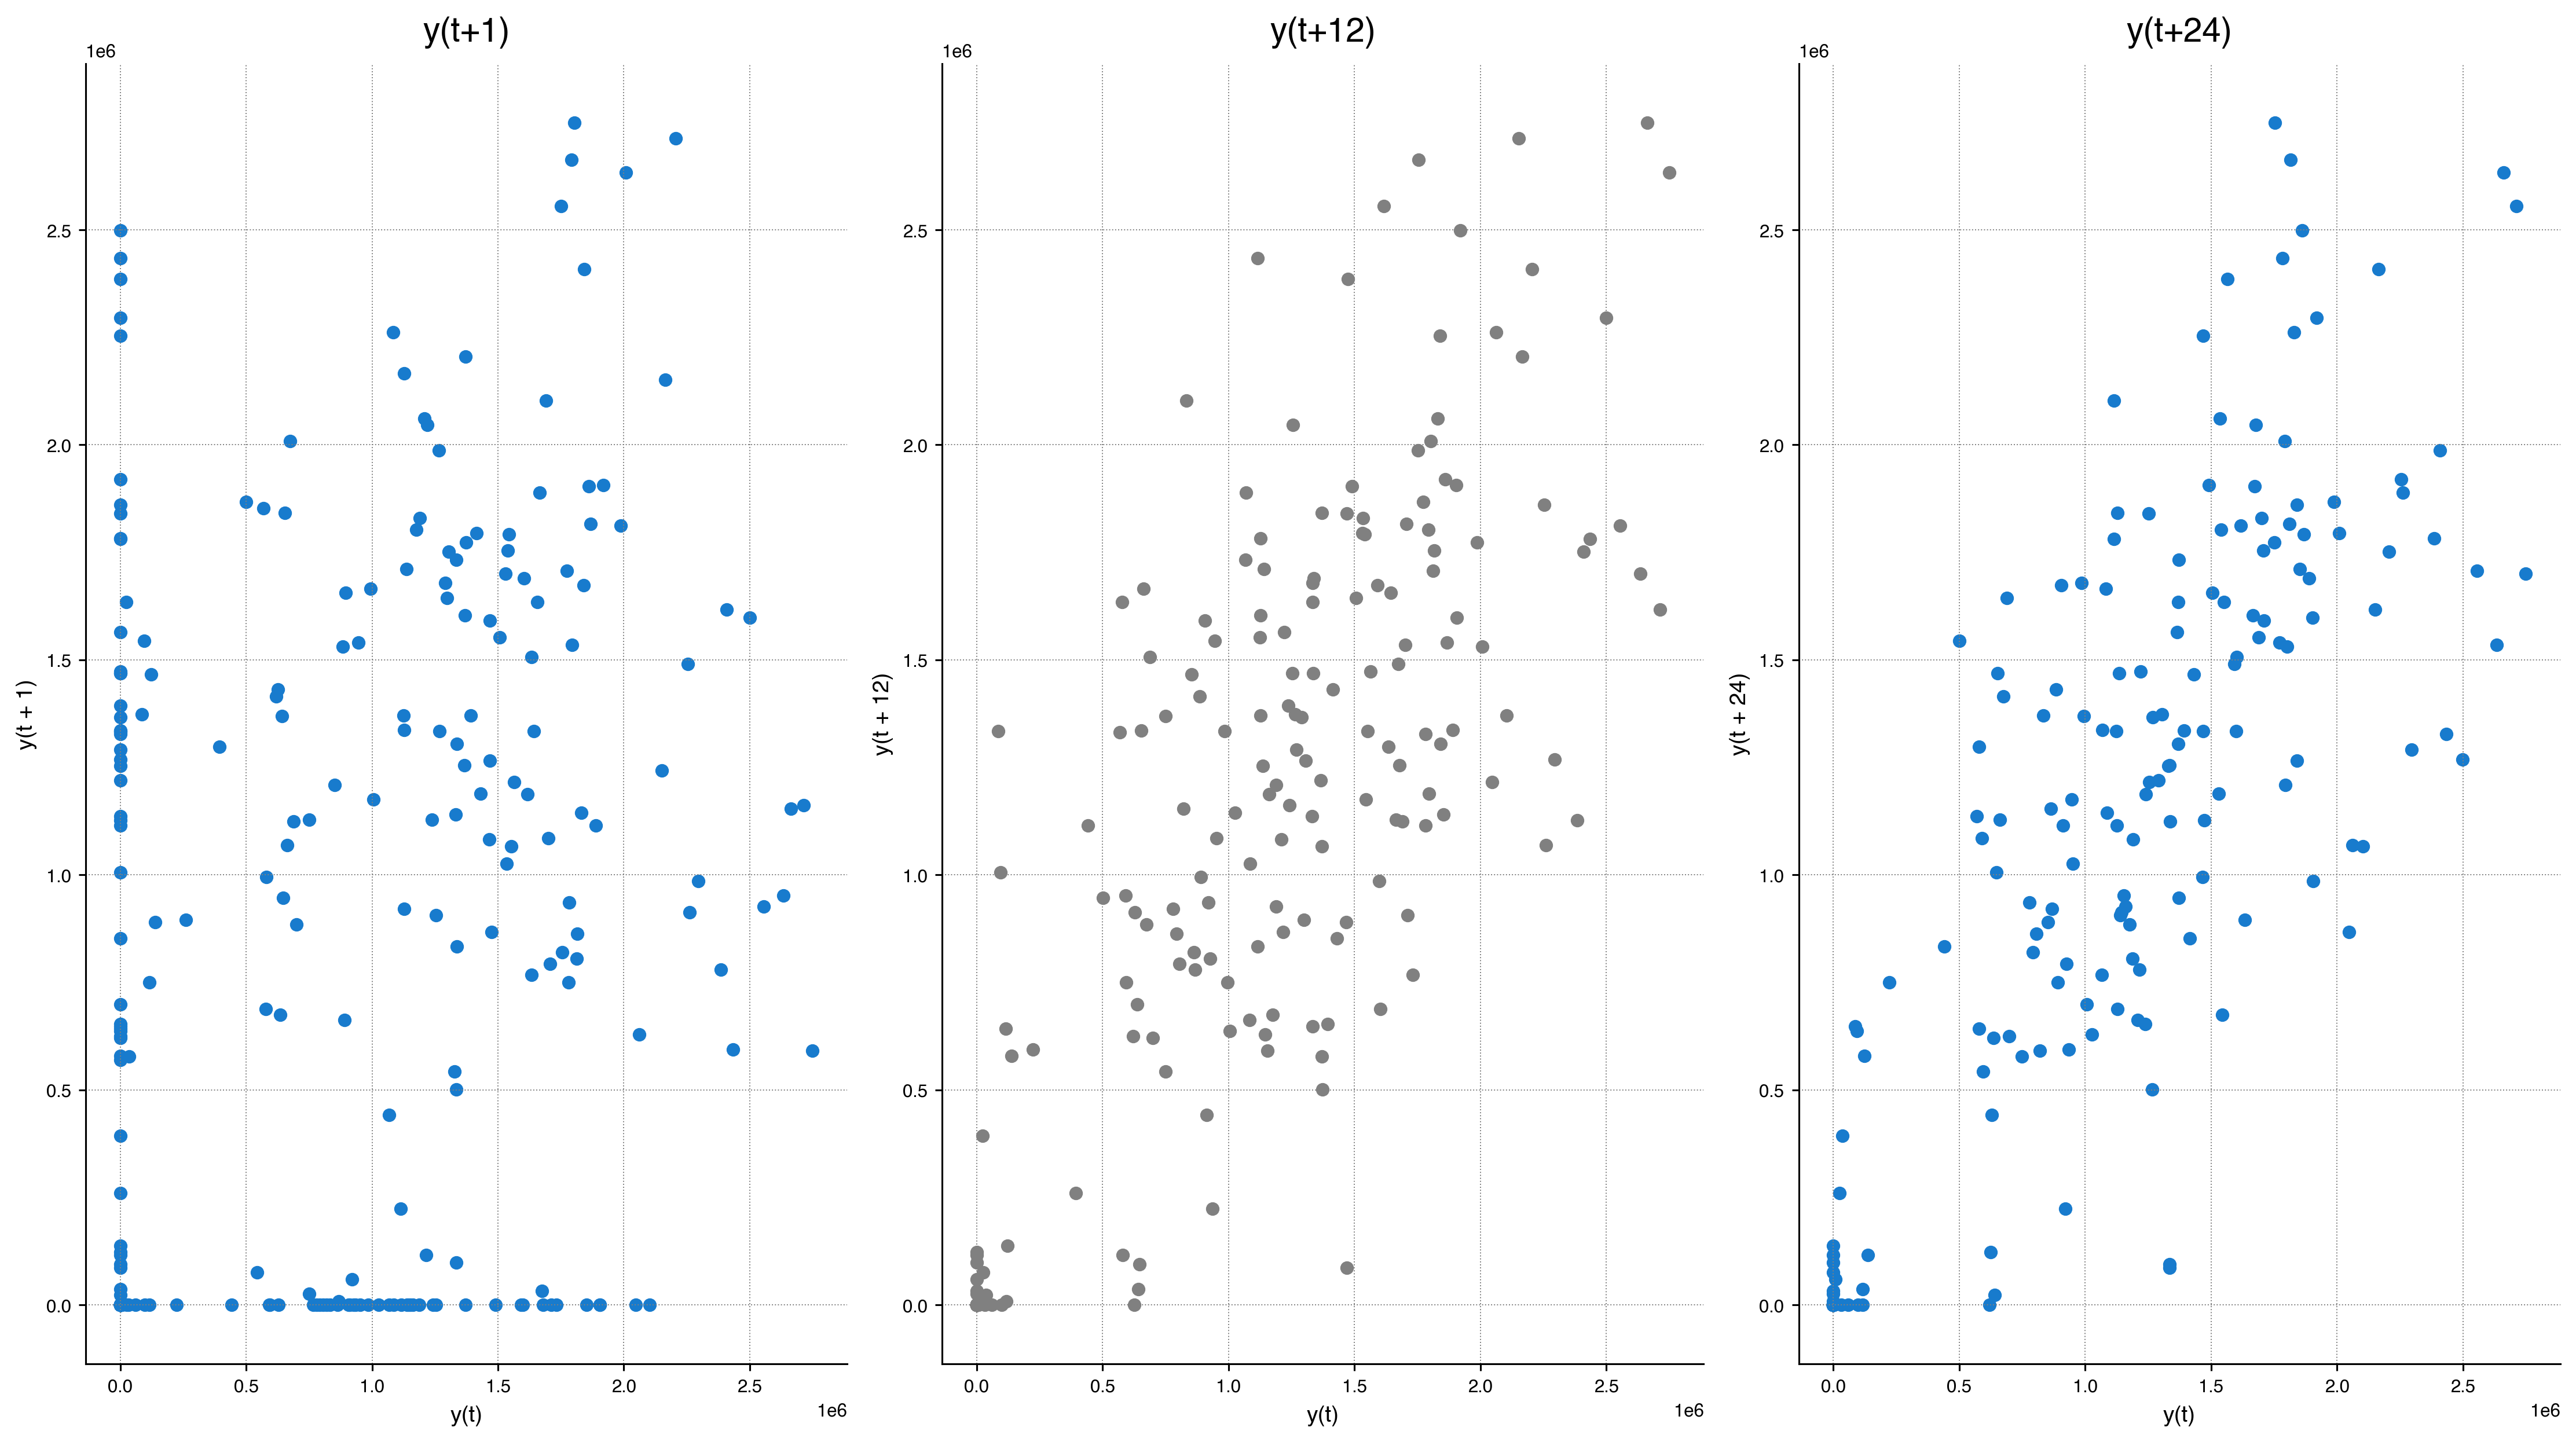

In [38]:
# Plot lag correlations for original series
lag_plots(monthly_data['cars_and_taxis_x'], lags=[1, 12, 24])  # Default lags

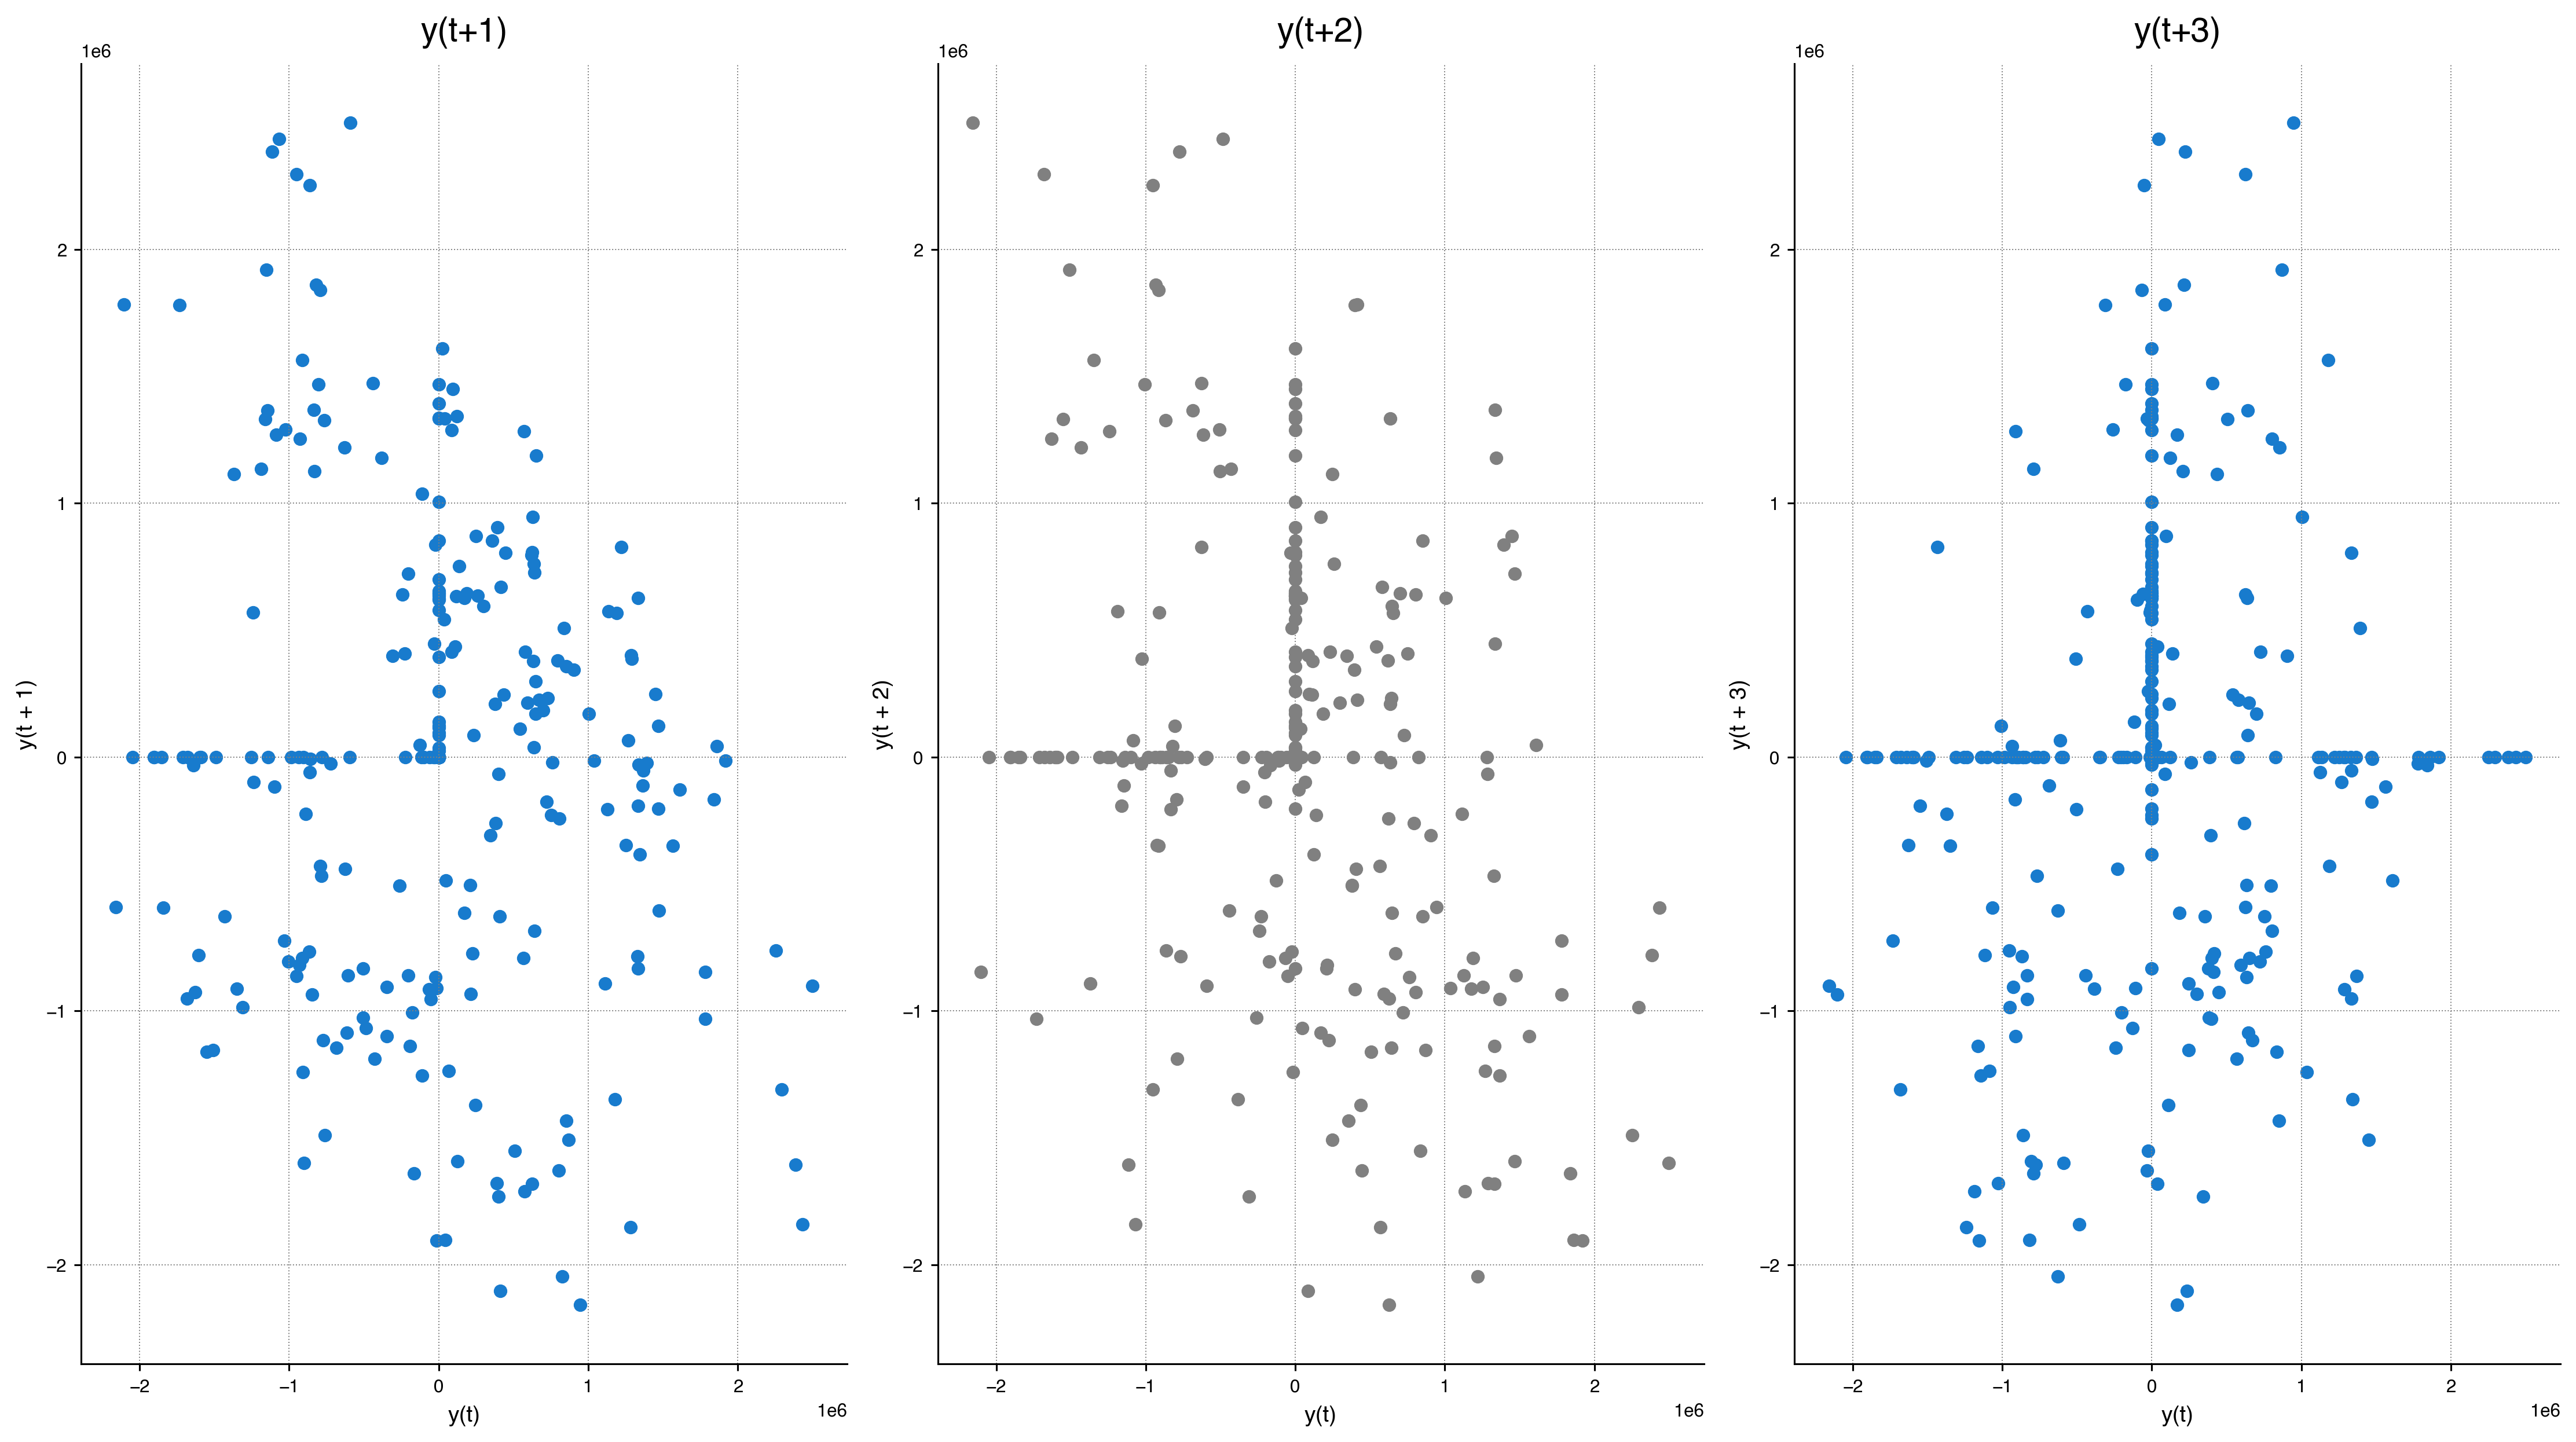

In [39]:
# Plot lag correlations for differenced series
lag_plots(diff_data, lags=[1, 2, 3])  # You can specify custom lags

### ACF and PACF Plots

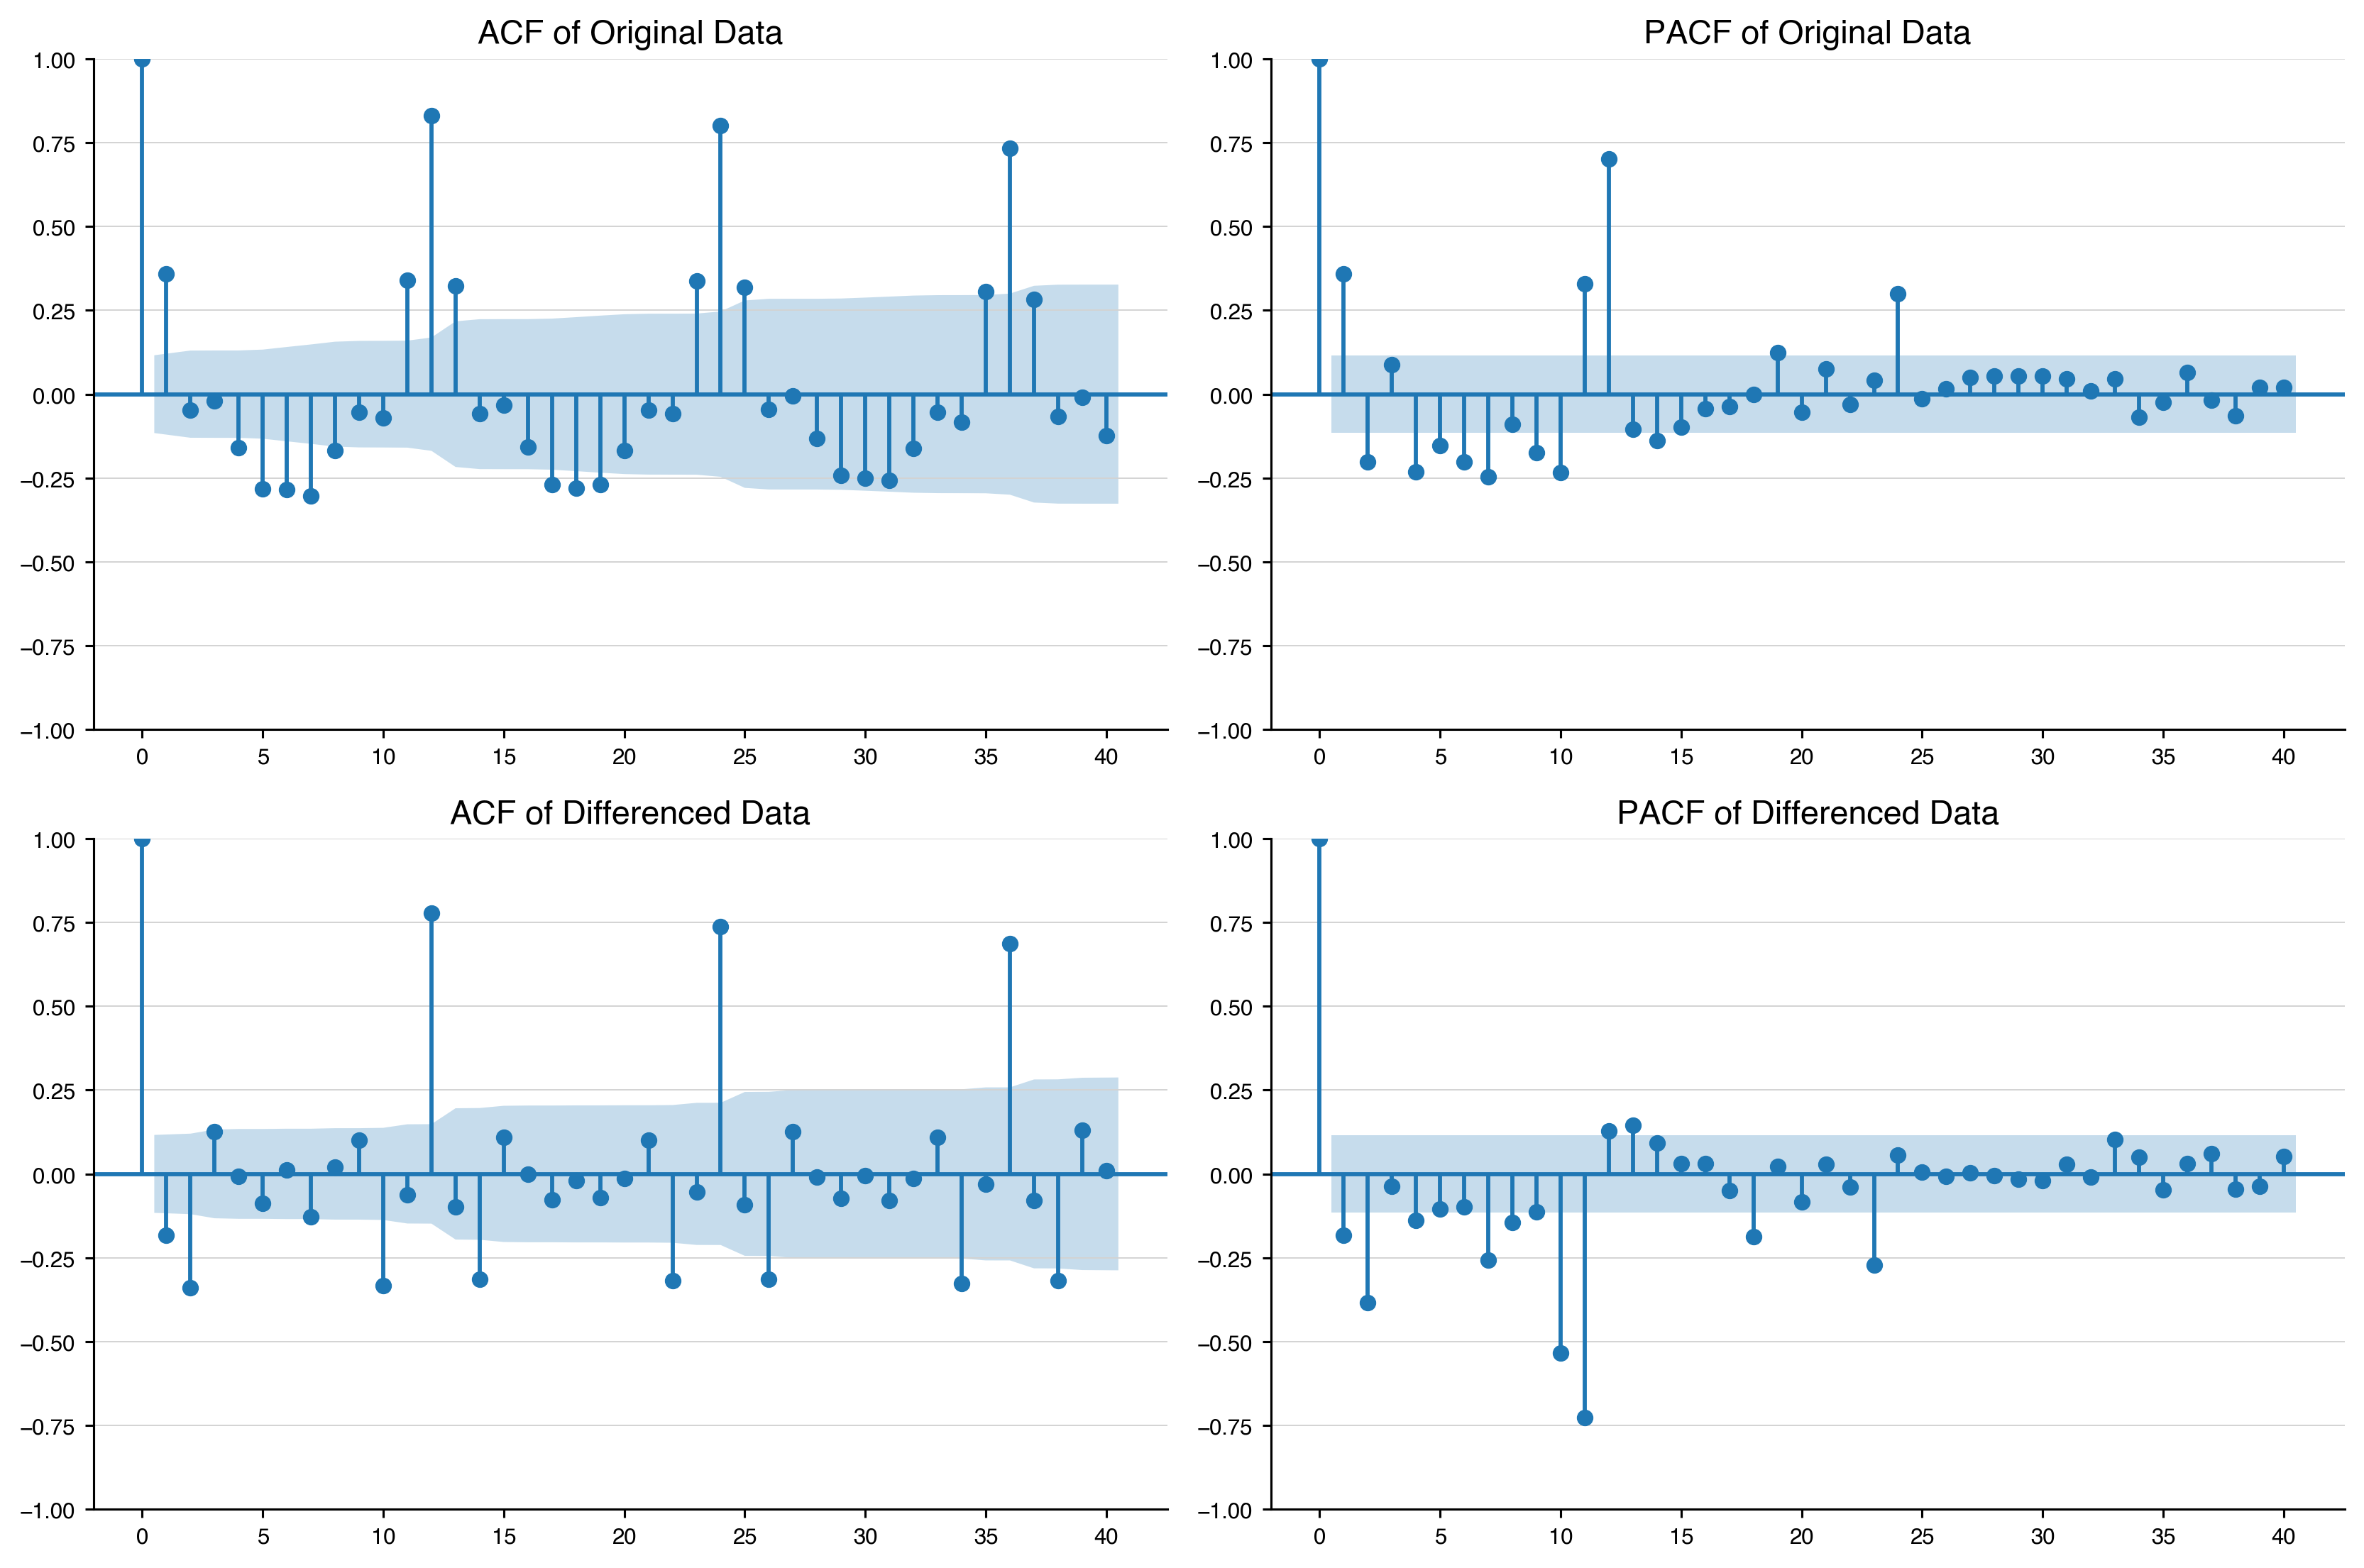

In [41]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Apply first-order differencing to the data
diff_data = monthly_data['cars_and_taxis_x'].diff().dropna()

# Create subplots for ACF and PACF
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(12, 8))

# Plot the ACF for the original data
plot_acf(monthly_data['cars_and_taxis_x'].dropna(), lags=40, ax=ax1[0])
ax1[0].set_title('ACF of Original Data')

# Plot the PACF for the original data
plot_pacf(monthly_data['cars_and_taxis_x'].dropna(), lags=40, ax=ax1[1])
ax1[1].set_title('PACF of Original Data')

# Plot the ACF for the differenced data
plot_acf(diff_data, lags=40, ax=ax2[0])
ax2[0].set_title('ACF of Differenced Data')

# Plot the PACF for the differenced data
plot_pacf(diff_data, lags=40, ax=ax2[1])
ax2[1].set_title('PACF of Differenced Data')

# Display the plots
plt.tight_layout()
plt.show()


## EDA: Decomposion

In [44]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose_series(series: pd.Series, period: int, title: str) -> None:
    """
    This function decomposes the time series into trend, seasonality, and residuals.
    
    Args:
        series (pd.Series): The time series data to decompose.
        period (int): The number of observations per cycle (e.g., 12 for monthly data).
        title (str): Title for the plot.
    
    Returns:
        None
    """
    # Decomposition
    decomposition = seasonal_decompose(series, model='additive', period=period)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot decomposition
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(16, 10), facecolor='w')

    ax1.plot(series, label='Original', color='blue')
    ax1.set_title('Original Series')
    ax1.legend()

    ax2.plot(trend, label='Trend', color='red')
    ax2.set_title('Trend')
    ax2.legend()

    ax3.plot(seasonal, label='Seasonality', color='green')
    ax3.set_title('Seasonality')
    ax3.legend()

    ax4.plot(residual, label='Residuals', color='orange')
    ax4.set_title('Residuals')
    ax4.legend()

    # Add title and layout adjustments
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


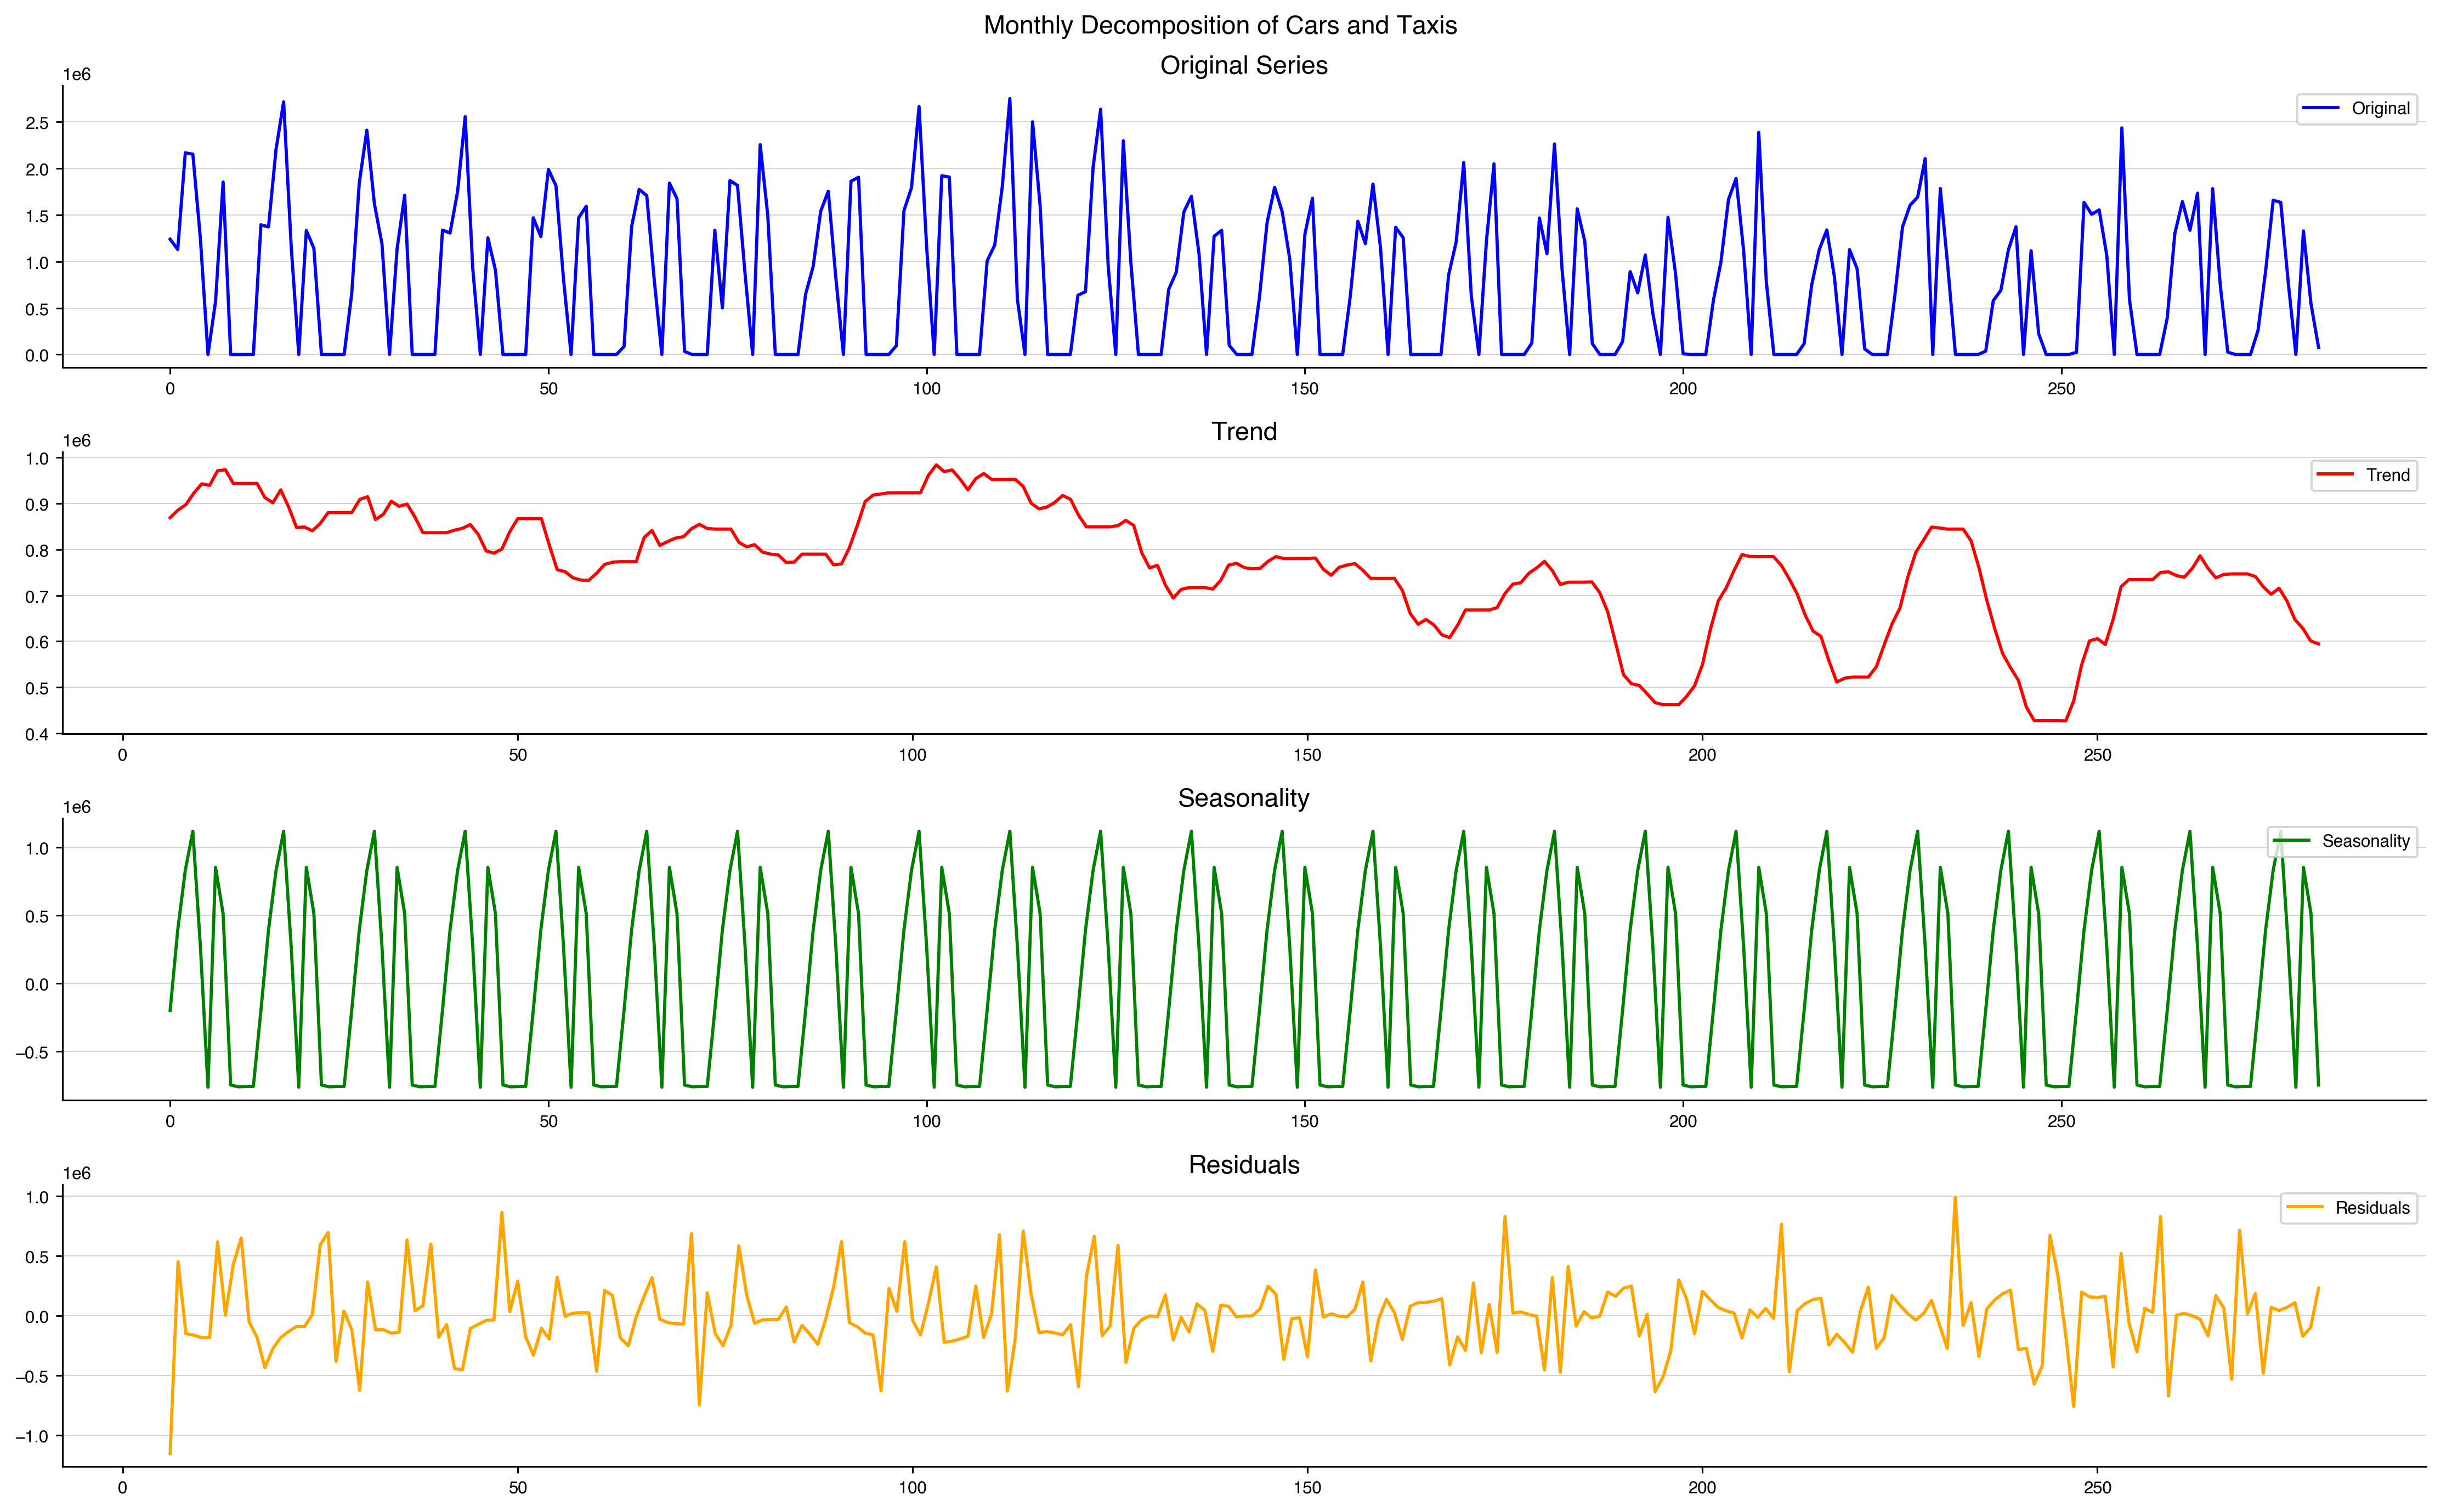

In [45]:
# Decompose the monthly data for 'cars_and_taxis_x'
decompose_series(monthly_data['cars_and_taxis_x'], period=12, title='Monthly Decomposition of Cars and Taxis')

## Modeling

### Train/Test Split

In [53]:
!pip install prophet

In [47]:
# Select the relevant columns for Prophet (ds = date, y = values to forecast)
prophet_data = merged_data[['count_date', 'cars_and_taxis_x']].rename(columns={'count_date': 'ds', 'cars_and_taxis_x': 'y'})

# Ensure there are no missing values
prophet_data = prophet_data.dropna()

# Inspect the prepared data
print(prophet_data.head())


          ds       y
0 2000-03-31  2804.0
1 2000-03-31  3100.0
2 2000-03-31  2235.0
3 2000-03-31  2259.0
4 2000-03-31  2428.0


In [51]:
# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(prophet_data) * 0.8)
train_data = prophet_data[:train_size]
test_data = prophet_data[train_size:]

# Inspect the training and testing data
print("Training data:")
print(train_data.head())
print("Testing data:")
print(test_data.head())


Training data:
          ds       y
0 2000-03-31  2804.0
1 2000-03-31  3100.0
2 2000-03-31  2235.0
3 2000-03-31  2259.0
4 2000-03-31  2428.0
Testing data:
               ds      y
439449 2018-06-05  280.0
439450 2018-06-05  247.0
439451 2018-06-05  142.0
439452 2018-10-18    6.0
439453 2018-10-18    4.0


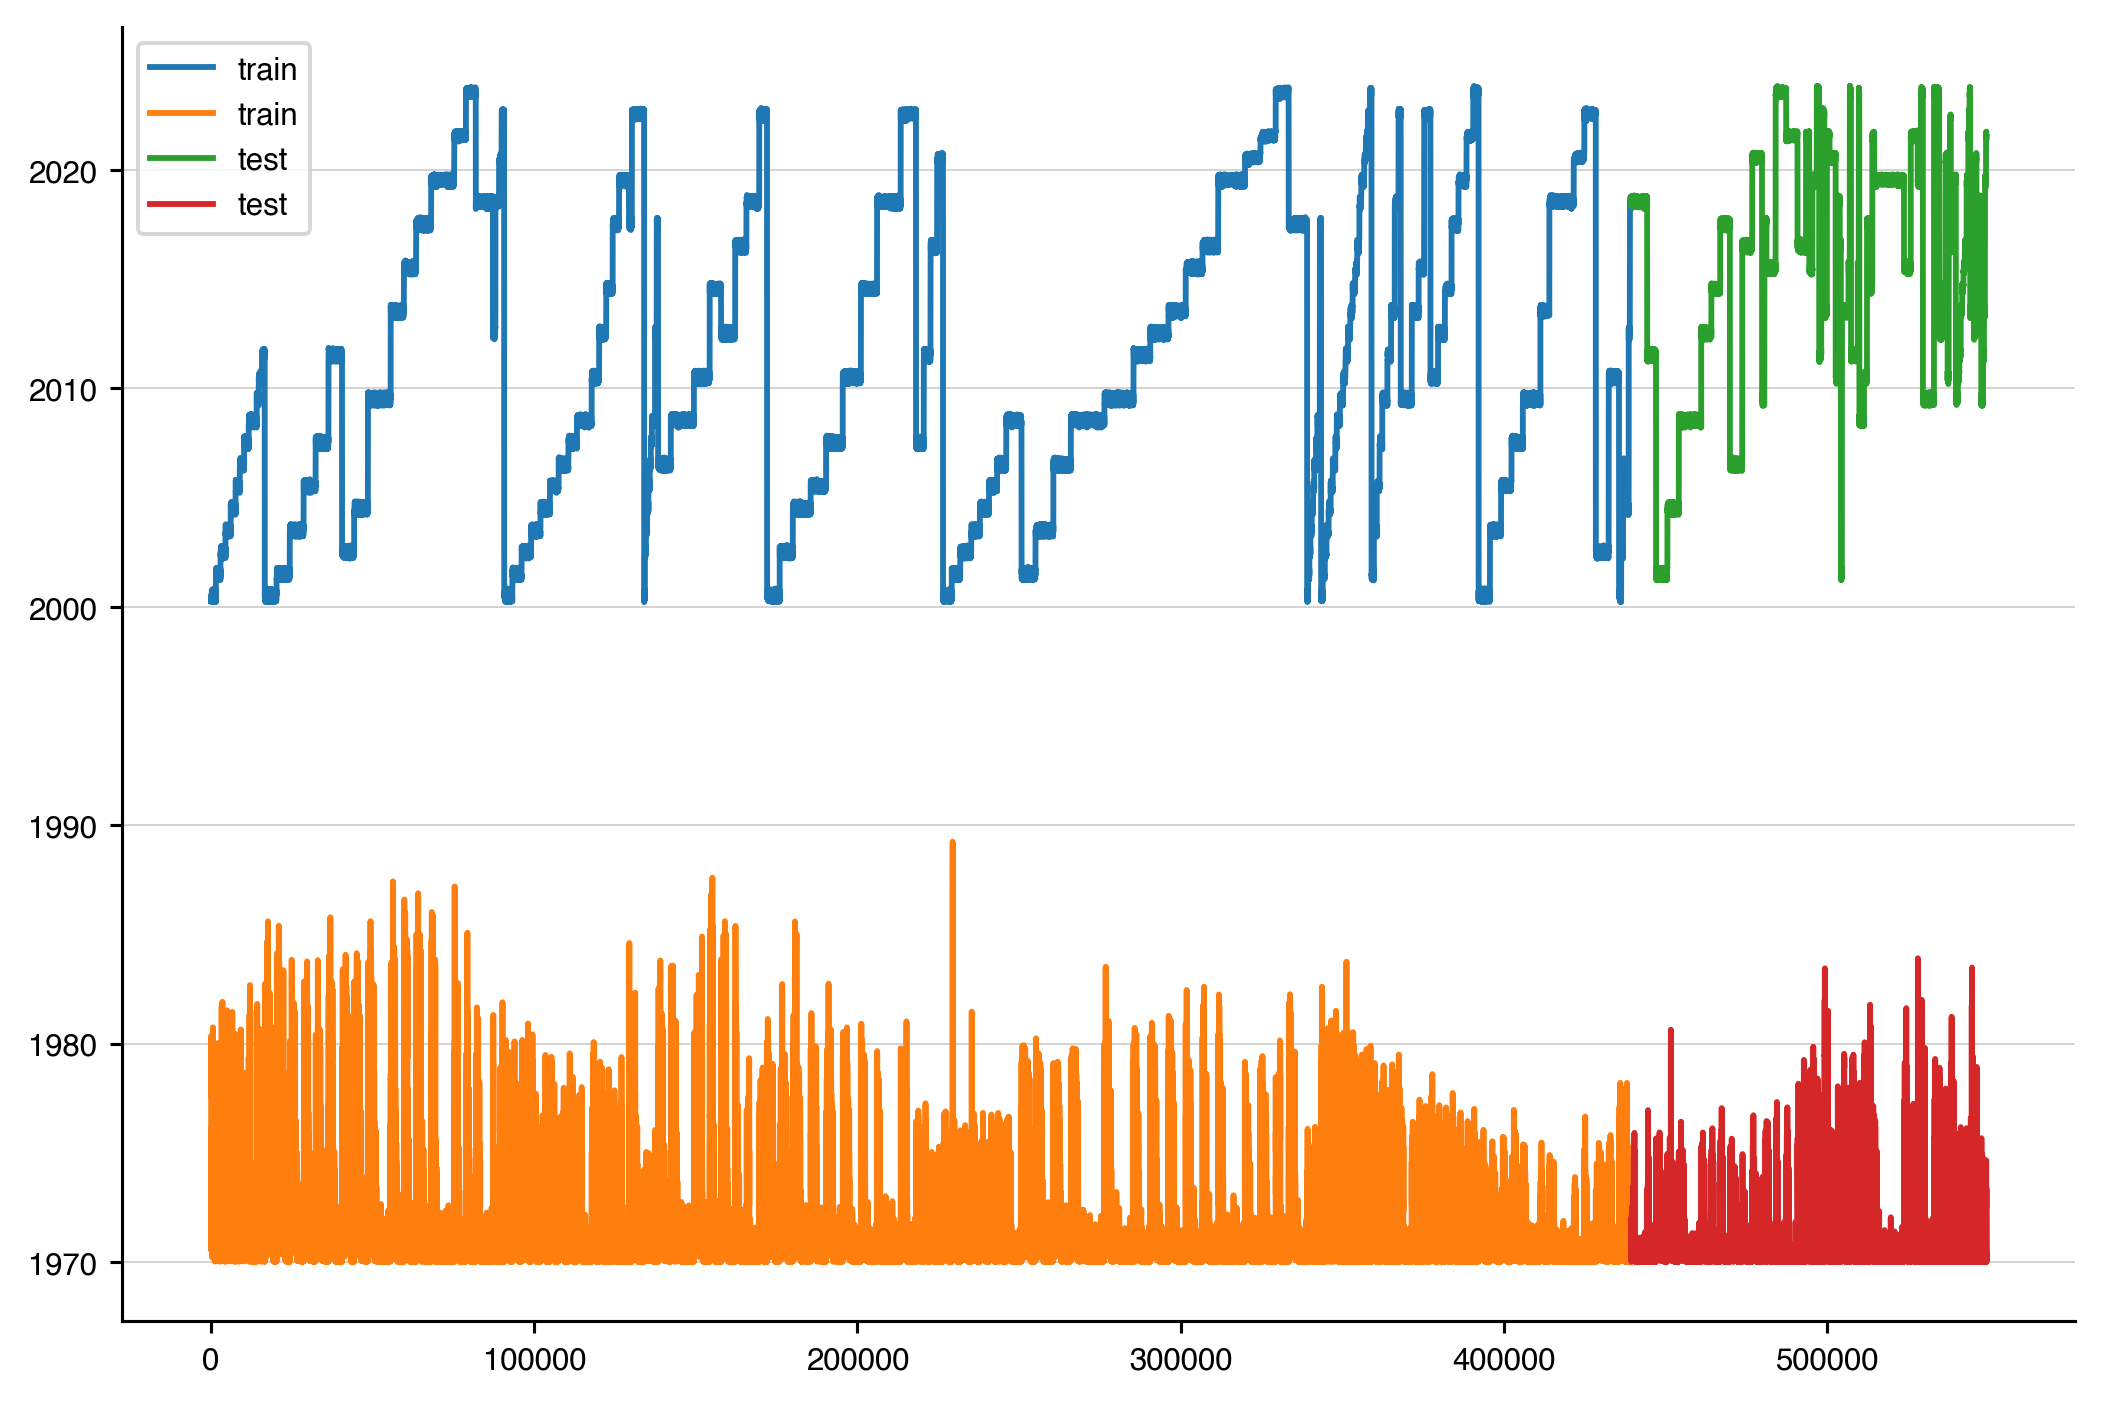

In [52]:
fig, ax = plt.subplots()
ax.plot(train_data, label="train")
ax.plot(test_data, label="test")
plt.legend()
plt.show()

07:35:30 - cmdstanpy - INFO - Chain [1] start processing
07:37:59 - cmdstanpy - INFO - Chain [1] done processing


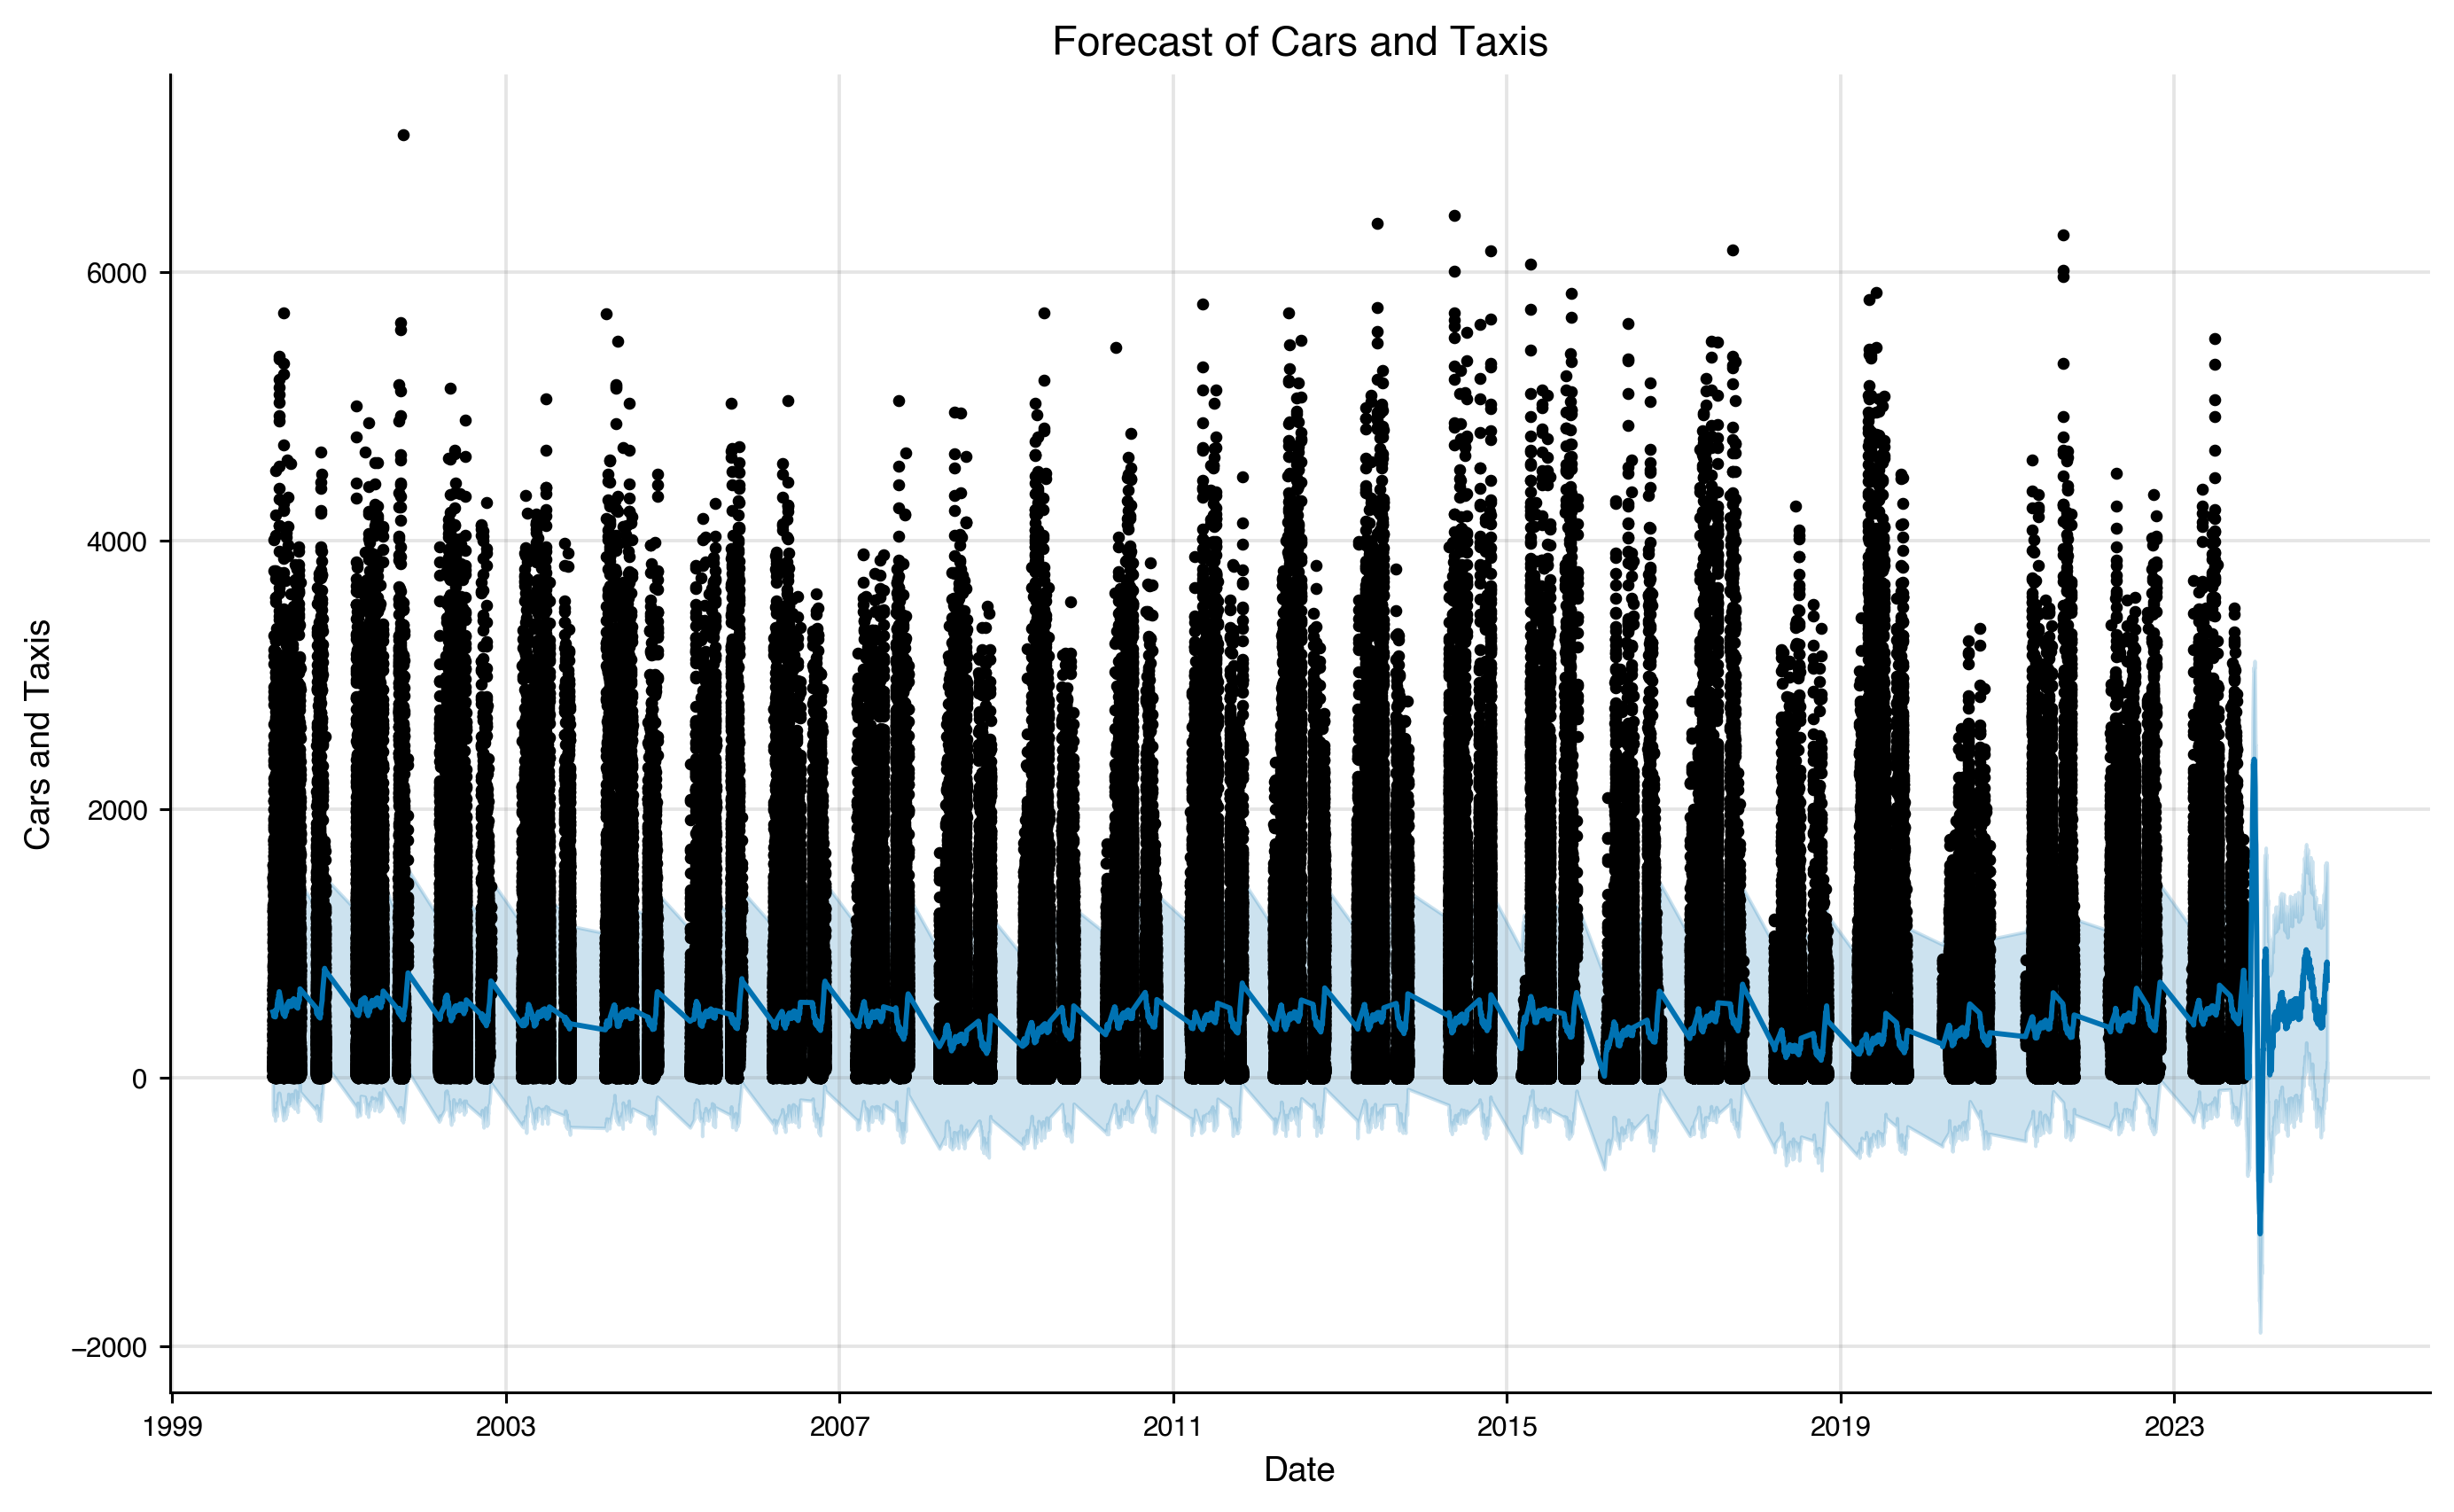

          ds        yhat  yhat_lower   yhat_upper
0 2000-03-17  489.892211 -241.334959  1218.356355
1 2000-03-20  474.701895 -279.599393  1209.937039
2 2000-03-21  456.846340 -251.126377  1157.514519
3 2000-03-22  490.002677 -264.433145  1245.784242
4 2000-03-23  473.411742 -240.815827  1232.261333


In [54]:
# Initialize the Prophet model
model = Prophet()

# Fit the model to the data
model.fit(prophet_data)

# Forecasting for 365 days into the future
future = model.make_future_dataframe(periods=365, freq='D')  

# Generate the forecast
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title('Forecast of Cars and Taxis')
plt.xlabel('Date')
plt.ylabel('Cars and Taxis')
plt.grid(True)
plt.show()

# Inspect the forecast DataFrame
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

In [56]:
print(train_data['ds'].min(), train_data['ds'].max())
print(test_data['ds'].min(), test_data['ds'].max())


2000-03-17 00:00:00 2023-11-03 00:00:00
2001-03-16 00:00:00 2023-11-03 00:00:00


### visualize the forecast components, such as trend and seasonality

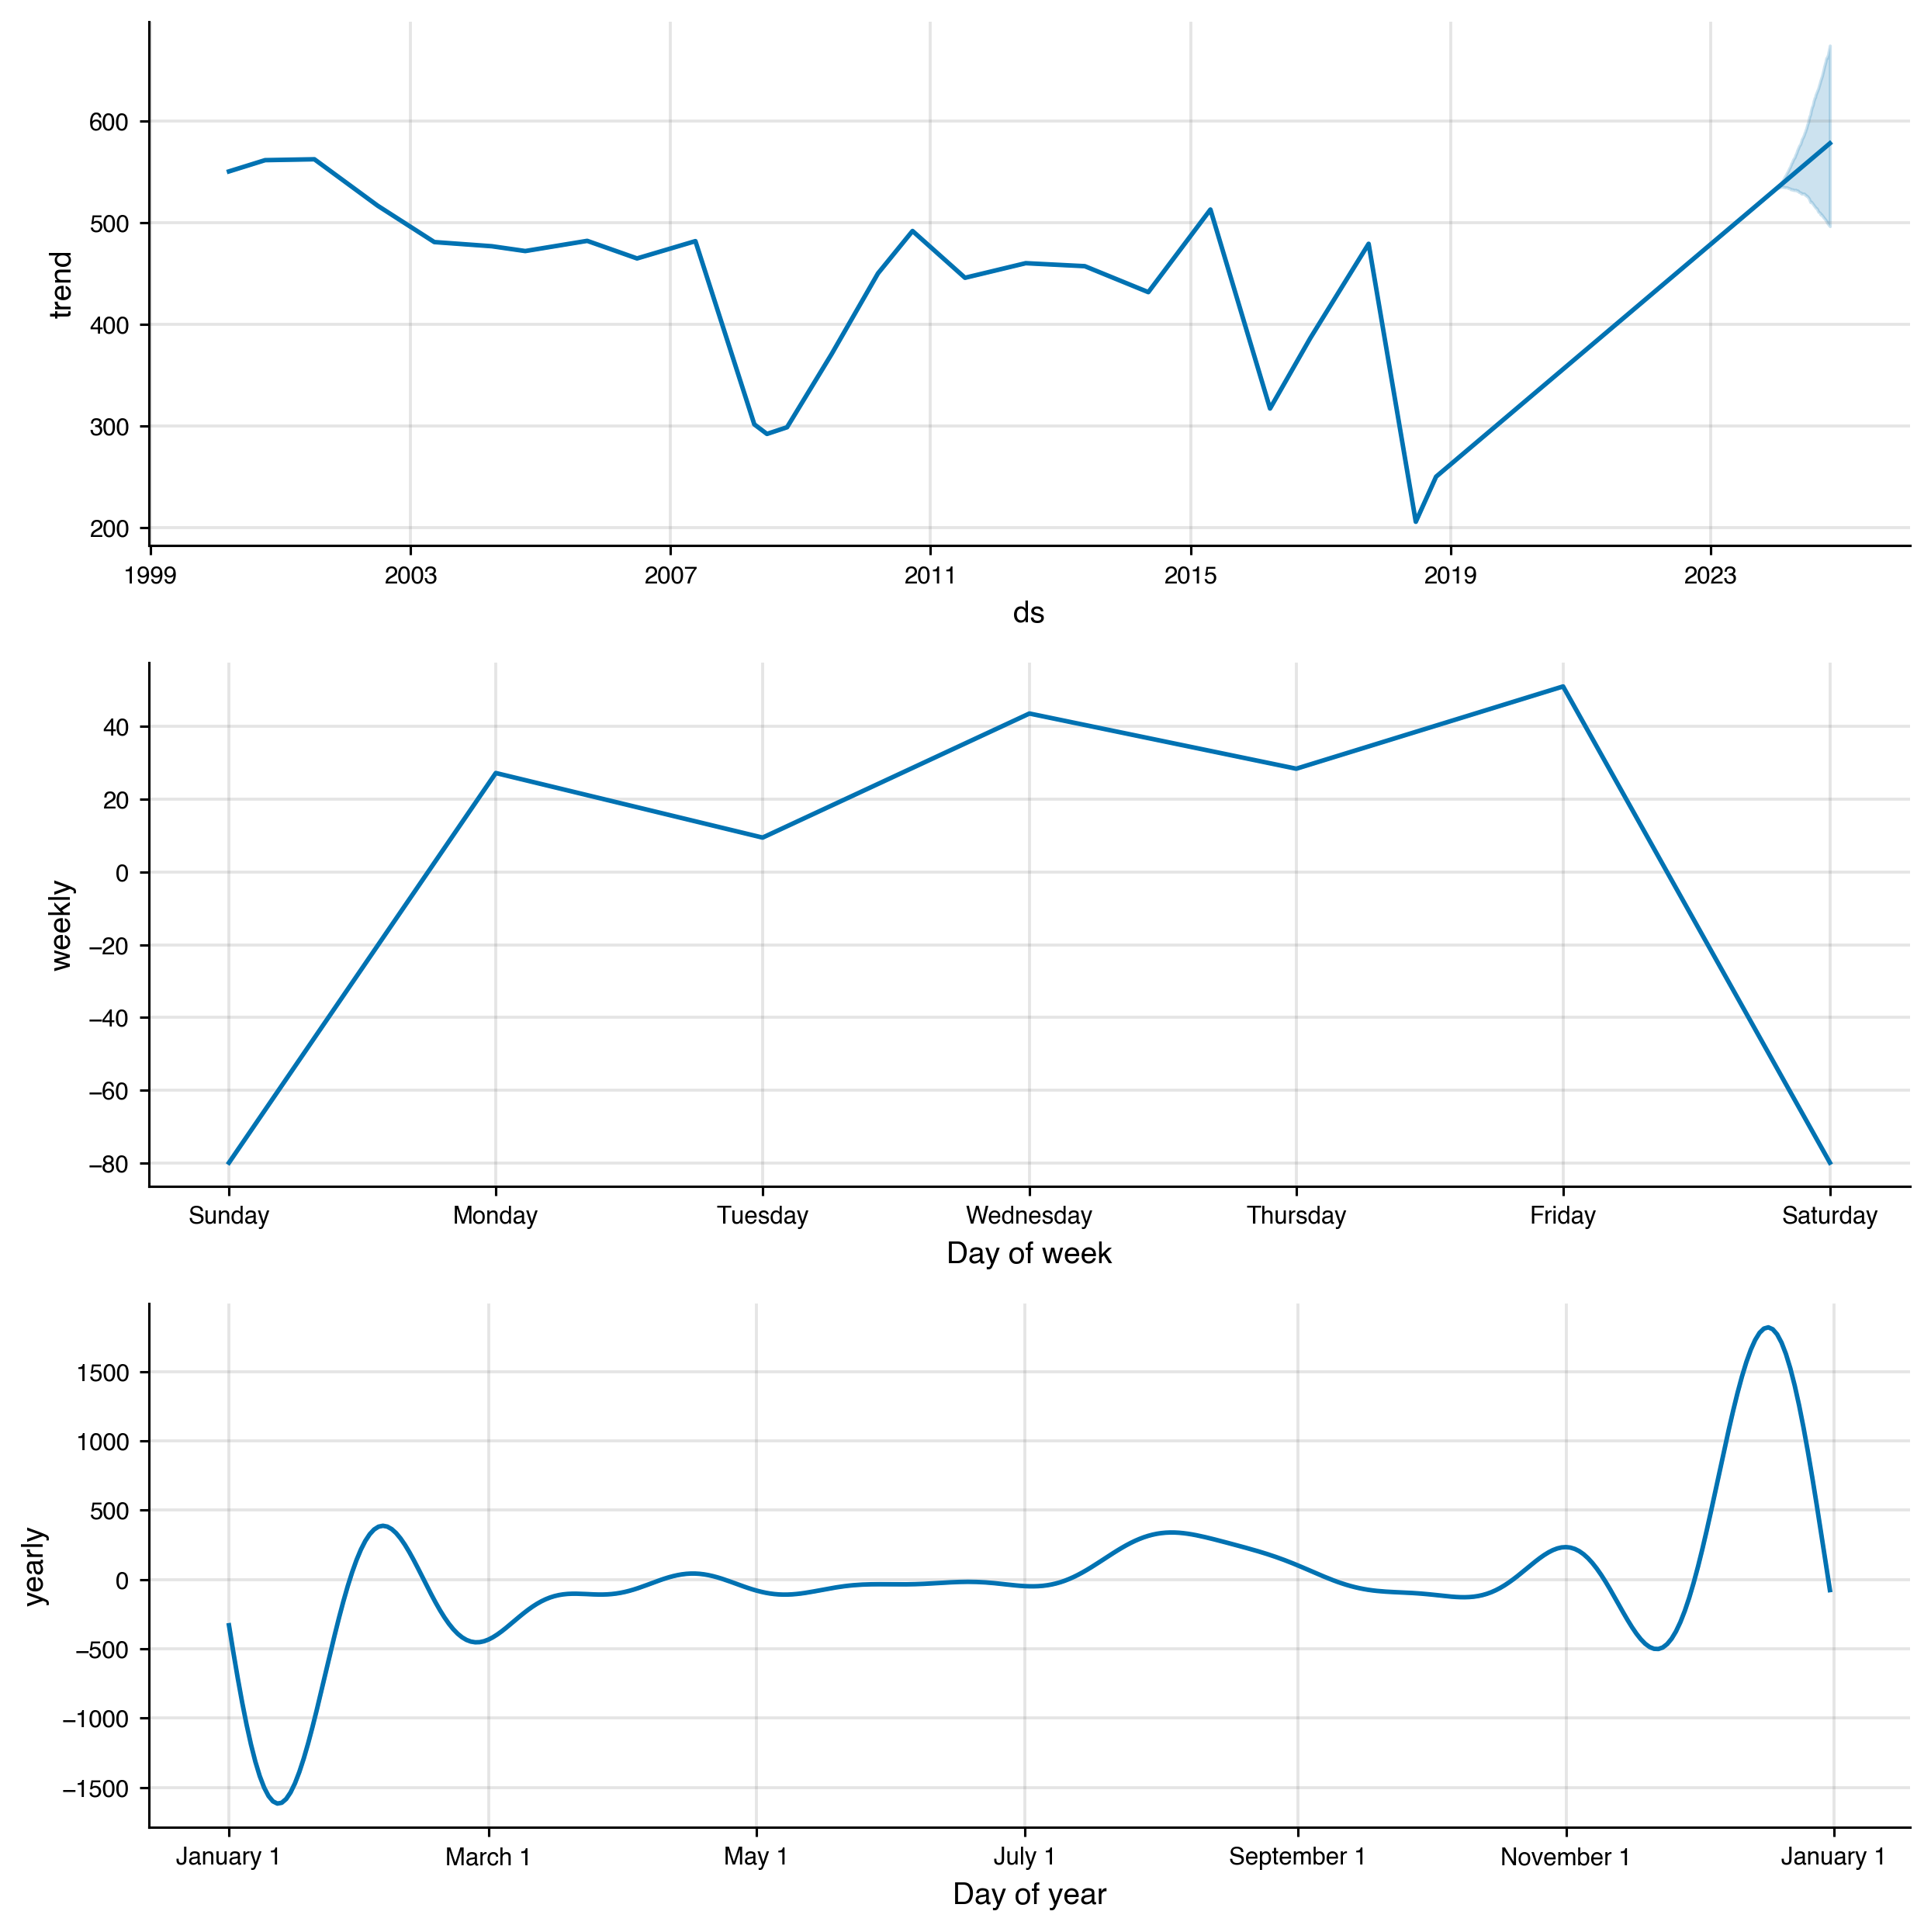

In [55]:
# Plot forecast components
model.plot_components(forecast)
plt.show()


### Model Evaluation

In [57]:
# Extract the relevant columns from the forecast and test data
forecasted_values = forecast[['ds', 'yhat']].set_index('ds')
actual_values = test_data.set_index('ds')  


comparison = actual_values.join(forecasted_values, how='left')


In [58]:

print(comparison.isnull().sum())  
print(np.isinf(comparison).sum()) 


y       0
yhat    0
dtype: int64
y       0
yhat    0
dtype: int64


In [59]:
# 
comparison_cleaned = comparison.replace([np.inf, -np.inf], np.nan).dropna()

# Calculate the MAE and RMSE using the cleaned data
mae = mean_absolute_error(comparison_cleaned['y'], comparison_cleaned['yhat'])
rmse = np.sqrt(mean_squared_error(comparison_cleaned['y'], comparison_cleaned['yhat']))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')


MAE: 335.5047024601543
RMSE: 449.7575228750173


In [61]:
comparison_cleaned['ds'] = test_data['ds']

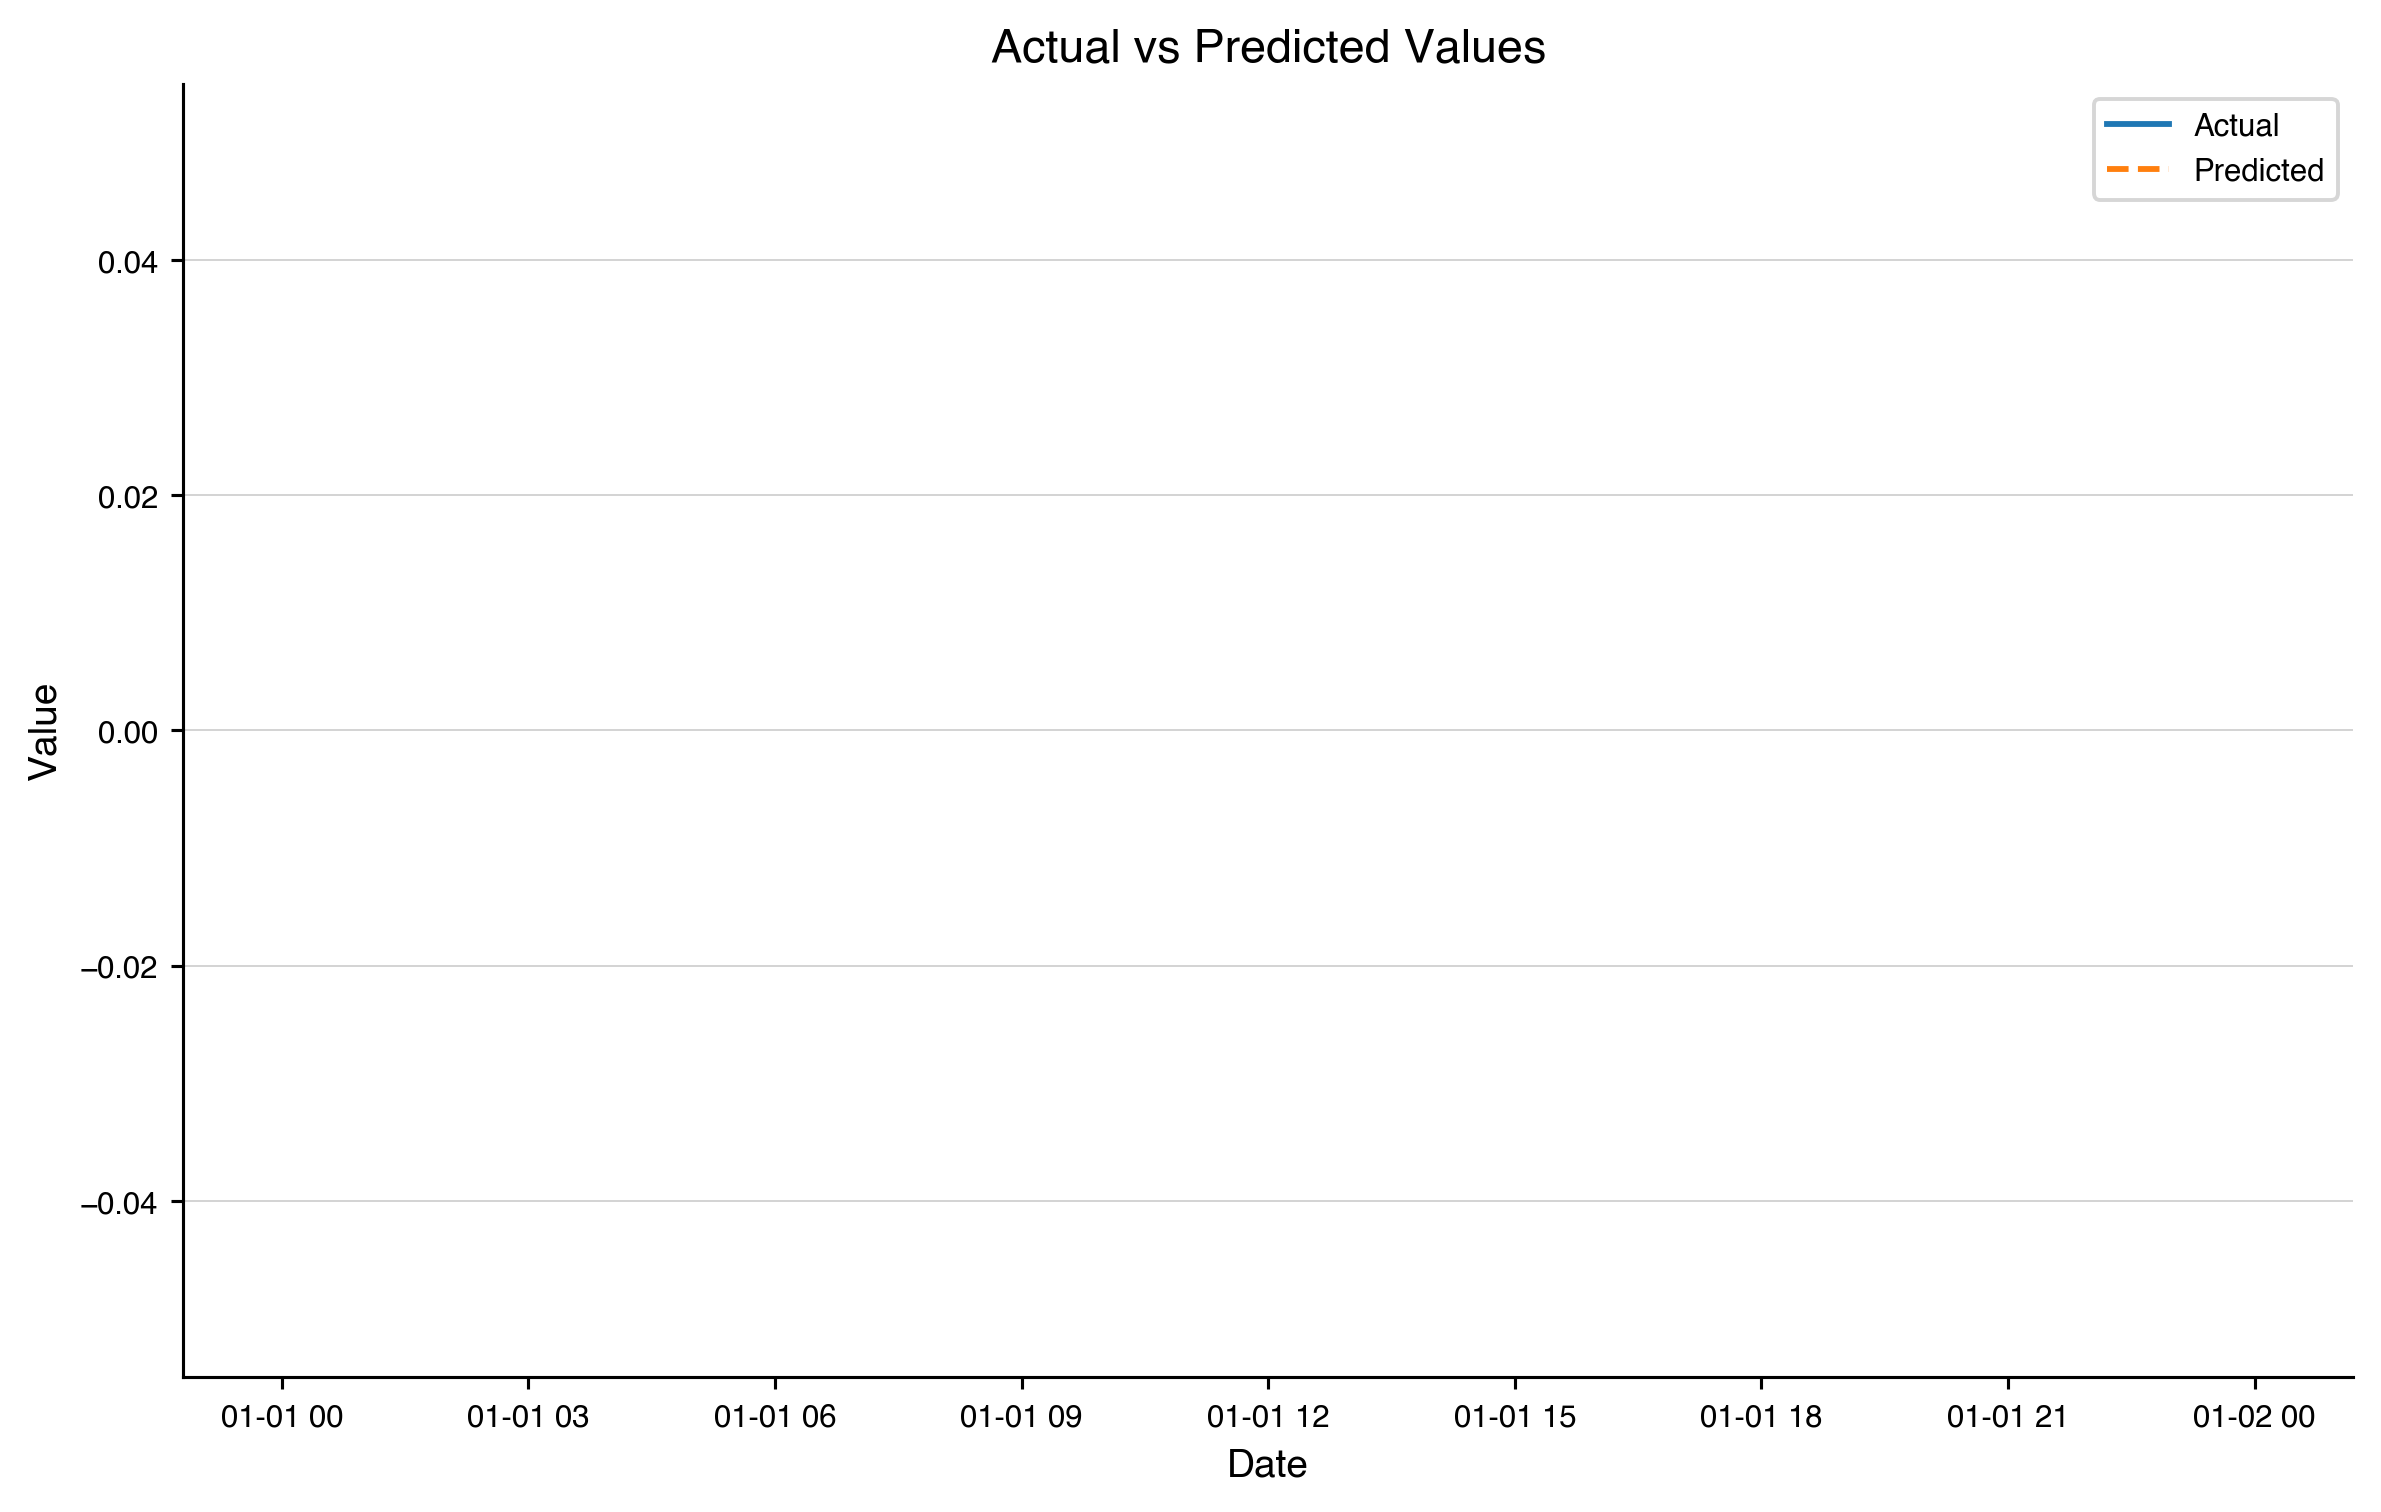

In [64]:
# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(comparison_cleaned['ds'], comparison_cleaned['y'], label='Actual')
plt.plot(comparison_cleaned['ds'], comparison_cleaned['yhat'], label='Predicted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()
